# **Data Analysis Cycle**

[![Open in Colab](http://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thekimk/All-About-Machine-Learning/blob/main/Practice2-4_DataAnalysis_Unsupervised_KK.ipynb)

<center><img src='Image/Advanced/DataAnalysis_Cycle0.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle1.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle2.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle3.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle4.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle5.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle6.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle7.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle8.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle9.png' width='800'></center>

# **Import Library:** 분석에 사용할 모듈 설치

In [1]:
!pip install --upgrade pip
!python -m pip install --user --upgrade pip

In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Datasets
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.datasets import fetch_lfw_people

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
# for classification
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import silhouette_score

In [3]:
# Classification Measure 함수화
def measures_cluster(Y, X, Y_pred):
    measures = [silhouette_score(X, Y_pred),
                adjusted_rand_score(Y, Y_pred), 
                adjusted_mutual_info_score(Y, Y_pred)]
    measures = pd.DataFrame(measures, index=['Silhouette', 'ARI', 'AMI'], columns=['Score']).T
    
    return measures

# Confusion Matrix 함수화
def evaluation_class_ConfusionMatrix(Y_true, Y_pred):
    conf_mat = confusion_matrix(Y_true, Y_pred)
    index_name = ['True '+str(i) for i in np.unique(np.array(Y_true))]
    column_name = ['Pred '+str(i) for i in np.unique(np.array(Y_true))]
    conf_mat = pd.DataFrame(conf_mat, index=index_name, columns=column_name)
    
    return conf_mat

# Classification Report 함수화
def evaluation_class_ClassificationReport(Y_true, Y_pred):
    print(classification_report(Y_true, Y_pred, 
                                target_names=['class 0', 'class 1']))


# ROC Curve & AUC 함수화
def evaluation_class_ROCAUC(Y_true, P_pred, figsize=(10,5), label='Logistic Regression'):
    fpr, tpr, thresholds = roc_curve(Y_true, P_pred)
    cm = evaluation_class_ConfusionMatrix(Y_true, P_pred>=0.5)
    recall = cm.iloc[1,1] / cm.sum(axis=1).values[1]
    fallout = cm.iloc[0,1] / cm.sum(axis=1).values[0]
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot([fallout], [recall], 'ro', ms=10)
    plt.title('AUC: ' + str(auc(fpr, tpr)), fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()

# **Applying Base Algorithm:** K-centroid Clustering

**1) 알고리즘 함수세팅:** 군집문제를 푸는 대표적인 알고리즘 `K-means Clustering`

> - 데이터의 영역을 대표하는 `클러스터 중심 찾기`
> - 가장 `단순하고 빠른 군집화` 방법의 하나
> - 비교적 `이해하기 쉽고` 구현도 쉬워 `가장 인기` 있는 군집 알고리즘
>
> (1) **Initialization:** `임의 공간 및 갯수`의 `클러스터 중심을 할당`
>
> (2) **Assignment:** `클러스터 중심`으로부터 `모든 데이터`에 대해 `가까운 클러스터`로 군집화 한다
>
> (3) **Update:** 각 클러스터 `내부 데이터들의 평균`으로 `중심 재지정`
>
> (4) **Finalization:** `클러스터 중심`이 변화가 없거나 `비용함수`가 일정 수치 이하가 될때까지 `Assignment & Update`를 반복
>
> <center><img src='Image/Advanced/Clustering_Kmeans.png' width='600'></center>
>
> <center><img src='Image/Advanced/Clustering_Kmeans_Video.gif' width='400'>(Wikipedia)</center>

---

**2) 함수 추정을 위한 비용함수:** 

> **"특정 출력(종속변수)/입력(독립변수)의 구분이나 `관계 추론도 없고` 학습을 위한 `목표값도 없이`, 주어진 데이터의 `레이블을 할당`하면서 `유사한 그룹으로 군집화(Clustering)` 하는 알고리즘"**

- **이슈: 군집의 `정답레이블이 없어` 지도학습과 달리 `명확한 모델링 평가 쉽지 않음`**    
- **방향:** 군집 `내부 유사성은 높임` + `외부` 군집들과의 `유사성은 낮춤`

> **"`응집도`와 `분리도`를 모두 만족하는 군집을 찾는 `최적화 과정`"**
> - **응집도(Cohesion):** 군집 중심과 `내부 데이터들의 유사성(거리)` 합이 `최소화`
>> - 군집 내 분산(Inner-cluster Variance) 최소화
> - **분리도(Seperation):** `군집들` 간의 `비유사성` 합이 `최대화`
>> - 군집 간 분산(Inter-cluster Variance) 최대화
>
> <center><img src='Image/Advanced/Cohesion_Separation.png' width='500'></center>

- **유사성 측정:** 

> - **컴퓨터의 데이터 분류:**
> 
> | **대분류** 	| **소분류** 	| **컴퓨터의 분류1** 	| **컴퓨터의 분류2** 	|
|:---:	|:---:	|:---:	|:---:	|
| **질적변수(Qualitative Variable)** 	| **-** 	| - | 범주형 |
|  	| **명목형 변수(Nominal Variable)** 	|  문자	|  범주형 |
|  	| **순위형 변수(Ordinal Variable)** 	|  숫자	|  범주형 |
| **양적변수(Quantitative Variable)** 	| **-** 	| - | 연속형 |
|  	| **이산형 변수(Discrete Variable)** 	|  숫자	| 연속형 |
|  	| **연속형 변수(Continuous Variable)** 	|  숫자	| 연속형 |
>
> - **측정 지표:** 
>
> | **변수 종류** 	| **측정** 	| **설명** 	|
|:---:	|:---:	|:---:	|
| **Continuous Variable** 	| **Manhattan Distance(Minkowski at Rank=1)** 	| 최단 루트 측정(변수들의 단위가 다르거나 상관성이 있으면 크게 변함) 	|
|  	| **Euclidean Distance(Minkowski at Rank=2)** 	| 최단 거리 측정(변수들의 단위가 다르거나 상관성이 있으면 크게 변함) 	|
|  	| **Standardized Distance** 	| 변수의 분산을 고려하여 표준화 측정 	|
|  	| **Mahalanobis Distance** 	| 변수의 표준화 및 변수들의 상관관계 측정 	|
|  	| **Weighted Euclidean Distance** 	| Euclidean & Standardized의 일반화 측정 	|
| **Continuous/Discrete Variable** 	| **Pearson's Correlation Coefficient** 	| 상관관계 측정 	|
| **Discrete(Binary)/Nominal Variable** 	| **Simple Matching Coefficient** 	| 수식 참고 	|
|  	| **Jaccard's Coefficient** 	| 수식 참고 	|
|  	| **Russell and Rao Coefficient** 	| 수식 참고 	|
| **Nominal Variable** 	| **Cosine Distance** 	| 문자 벡터들의 각도 측정 	|
|  	| **Levenshtein Metric** 	| 문자 벡터들에서 다른 단어로 변경시 필요한 편집수 측정 	|
|  	| **Tanimoto Coefficient(Expanded Jaccard's Coefficient)** 	| 문자 벡터 적용 Jaccard's Coefficient 	|
| **Ordinal Variable** 	| **Rank Correlation Coefficient** 	| 순위기반 상관관계 측정 	|
| **Continuous/Discrete/Nominal/Ordinal** 	| **Hamming Distance** 	| 같은 길이의 데이터에 같은 위치에 있는 값들의 비교 측정 	|
>
> - **비용함수:** `K-means Clustering`은 `Euclidean Distance`를 비용함수로 `최적화`
>
> $$
\begin{aligned}
Cost &= \sum_{i=1}^{N}\min_{\mu_j \in C}(||x_i - \mu_j||^2) \\
& \text{where } C \text{ is the estimated cluster,} \\
& \text{and } \mu_j \text{ is the average center of } j \text{-th cluster.}
\end{aligned}
$$

---

**3) K-centroid Clustering:**

> - **`K-means Clustering`:** 비용함수에서 `평균` 사용 군집화
> - **`K-median Clustering`:** 비용함수에서 `중앙값(Median)` 사용 군집화
> - **연속형 데이터**: `K-means Clustering` 또는 `K-median Clustering`
> - **이산형 데이터**: `K-mode Clustering` 또는 `K-medoid Clustering`

## 변수들의 관계성 확인하기

In [4]:
# 종속변수와 독립변수의 관계 확인을 위해 데이터 붙여서 DataFrame 전환
X, Y = make_blobs(n_samples=1000, n_features=2, centers=2, random_state=123)
df = pd.DataFrame(np.column_stack((Y,X)), columns=['Y', 'X1', 'X2'])
df

,Y,X1,X2
0,0.00,4.65,-5.28
1,0.00,4.89,-5.15
2,1.00,-5.32,1.05
3,1.00,-6.53,1.80
4,0.00,4.21,-2.68
...,...,...,...
995,1.00,-4.65,2.19
996,0.00,3.53,-4.40
997,0.00,6.26,-3.93
998,0.00,3.11,-4.90


In [5]:
# 종속변수와 독립변수의 상관관계 확인하기
df.corr()

,Y,X1,X2
Y,1.00,-0.98,0.94
X1,-0.98,1.00,-0.92
X2,0.94,-0.92,1.00


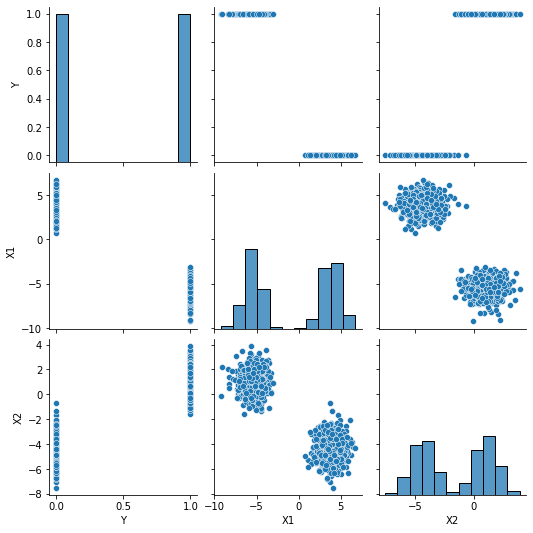

In [6]:
# seaborn 함수를 sns로 사용하여 pairplot 그리기
sns.pairplot(df)
plt.show()

## K-means Clustering 추정, 예측, 검증

In [7]:
# 알고리즘 불러오기 및 스케일링
X, Y = make_blobs(n_samples=1000, n_features=2, centers=2, random_state=123)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 1.13687766, -1.27825715],
       [ 1.18656692, -1.23554346],
       [-0.94773747,  0.9416529 ],
       ...,
       [ 1.47427863, -0.8066294 ],
       [ 0.81523661, -1.14611163],
       [ 0.85490684, -1.41681394]])

In [8]:
# X 데이터 학습
# KMeans 초기값은 기본적으로 K-means++ 방식 사용
model_kmeans = KMeans(n_clusters=2, random_state=123, init='k-means++')
model_kmeans.fit(X)

KMeans(n_clusters=2, random_state=123)

In [9]:
# 학습 모델로 예측하기
# Train 예측치 출력
Y_pred = model_kmeans.predict(X)
Y_pred

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [10]:
# 예측 클러스터 별 샘플 갯수 Table
pd.Series(Y_pred).value_counts(sort=True)

0    500
1    500
dtype: int64

In [11]:
# 각 클러스터의 중심위치 확인 가능
model_kmeans.cluster_centers_

array([[ 0.97825003, -0.94060386],
       [-0.97825003,  0.94060386]])

In [12]:
# 응집도 출력
model_kmeans.inertia_

158.29126377039532

In [13]:
# 검증지표 ARI 추정
adjusted_rand_score(Y, Y_pred)

1.0

In [14]:
# 검증지표 AMI 추정
adjusted_mutual_info_score(Y, Y_pred)

1.0

In [15]:
# 실루엣 검증지표
silhouette_score(X, Y_pred)

0.818232292709732

In [16]:
# 검증지표 정리
def measures_cluster(Y, X, Y_pred):
    measures = [silhouette_score(X, Y_pred),
                adjusted_rand_score(Y, Y_pred), 
                adjusted_mutual_info_score(Y, Y_pred)]
    measures = pd.DataFrame(measures, index=['Silhouette', 'ARI', 'AMI'], columns=['Score']).T
    
    return measures

measures_cluster(Y, X, Y_pred)

,Silhouette,ARI,AMI
Score,0.82,1.00,1.00


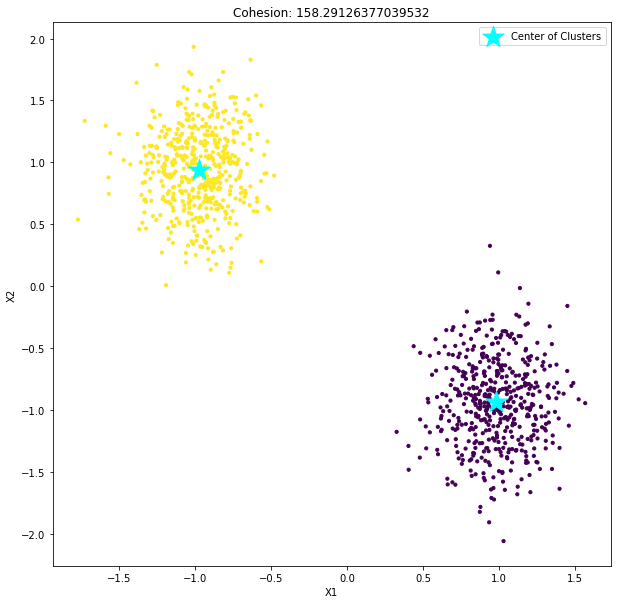

In [17]:
# scatter plot으로 원데이터와 클러스터 중심 모두 시각화
# title로 응집도 및 ARI 표시
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], 
            s=10, c=model_kmeans.labels_) 
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            marker='*', s=500,
            color='cyan', label='Center of Clusters')
plt.legend(loc='best')
plt.title('Cohesion: ' + str(model_kmeans.inertia_))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

,Silhouette,ARI,AMI
Score,0.59,0.75,0.80


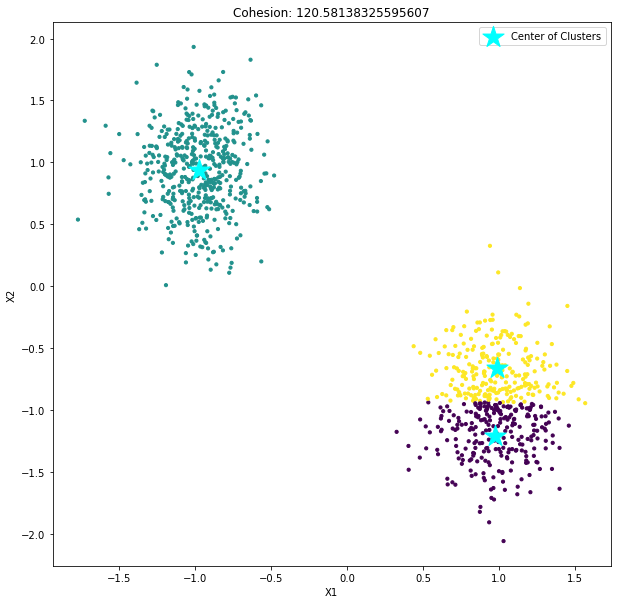

In [18]:
# 클러스터를 3개로 군집화 한 결과
# 클러스터 별 샘플수도 출력
model_kmeans = KMeans(n_clusters=3, random_state=123, init='k-means++')
model_kmeans.fit(X)
Y_pred = model_kmeans.predict(X)

display(measures_cluster(Y, X, Y_pred))

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], 
            s=10, c=model_kmeans.labels_) 
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            marker='*', s=500,
            color='cyan', label='Center of Clusters')
plt.legend(loc='best')
plt.title('Cohesion: ' + str(model_kmeans.inertia_))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

,Silhouette,ARI,AMI
Score,0.59,0.75,0.80


,Silhouette,ARI,AMI
Score,0.39,0.50,0.67


,Silhouette,ARI,AMI
Score,0.37,0.43,0.61


,Silhouette,ARI,AMI
Score,0.33,0.35,0.56


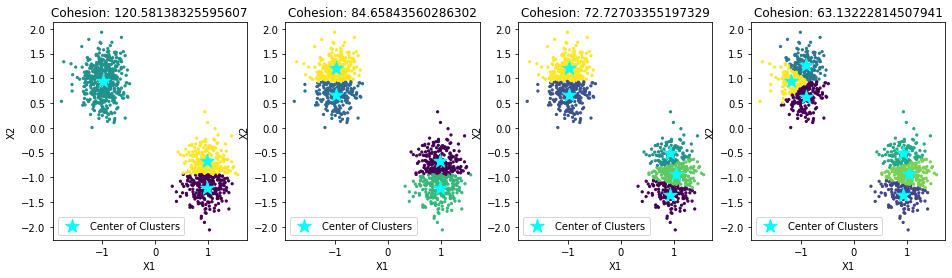

In [19]:
# 클러스터를 3개부터 6개까지로 군집된 결과
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

for num, K in enumerate(range(3,7)):
    model_kmeans = KMeans(n_clusters=K, random_state=123, init='k-means++')
    model_kmeans.fit(X)
    Y_pred = model_kmeans.predict(X)
    
    display(measures_cluster(Y, X, Y_pred))
    
    axes[num].scatter(X[:,0], X[:,1], 
                s=5, c=model_kmeans.labels_) 
    axes[num].scatter(model_kmeans.cluster_centers_[:, 0], 
                model_kmeans.cluster_centers_[:, 1], 
                marker='*', s=200,
                color='cyan', label='Center of Clusters')
    axes[num].legend(loc='best')
    axes[num].set_title('Cohesion: ' + str(model_kmeans.inertia_))
    axes[num].set_xlabel('X1')
    axes[num].set_ylabel('X2')
plt.show()

,Silhouette,ARI,AMI
Score,0.60,0.75,0.80


,Silhouette,ARI,AMI
Score,0.39,0.51,0.67


,Silhouette,ARI,AMI
Score,0.35,0.42,0.61


,Silhouette,ARI,AMI
Score,0.31,0.35,0.56


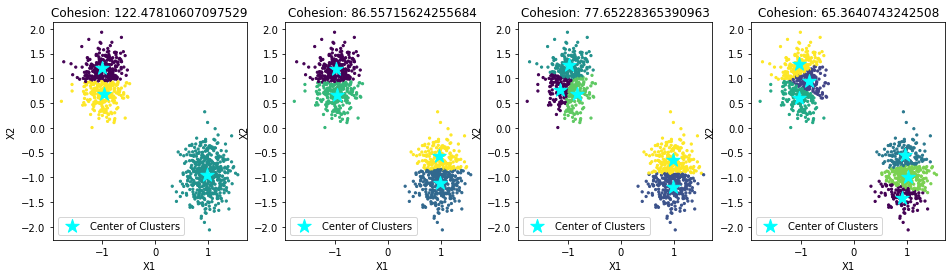

In [20]:
# 클러스터를 3개부터 6개까지로 군집된 결과
# K-means 대신에 Mini Batch K Means 사용
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

for num, K in enumerate(range(3,7)):
    model_kmeans = MiniBatchKMeans(n_clusters=K, batch_size=1000, random_state=123)    # 변경
    model_kmeans.fit(X)
    Y_pred = model_kmeans.predict(X)
    
    display(measures_cluster(Y, X, Y_pred))
    
    axes[num].scatter(X[:,0], X[:,1], 
                s=5, c=model_kmeans.labels_) 
    axes[num].scatter(model_kmeans.cluster_centers_[:, 0], 
                model_kmeans.cluster_centers_[:, 1], 
                marker='*', s=200,
                color='cyan', label='Center of Clusters')
    axes[num].legend(loc='best')
    axes[num].set_title('Cohesion: ' + str(model_kmeans.inertia_))
    axes[num].set_xlabel('X1')
    axes[num].set_ylabel('X2')
plt.show()

In [21]:
# 실제 미래 값 예측을 위한 새로운 샘플 데이터 생성
np.random.seed(100)
X_new1 = np.random.uniform(low=-5, high=5, size=20)
X_new2 = np.random.uniform(low=-8, high=4, size=20)
X_new = np.column_stack((X_new1, X_new2)) 
scaler = preprocessing.StandardScaler()
X_new = scaler.fit_transform(X_new)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


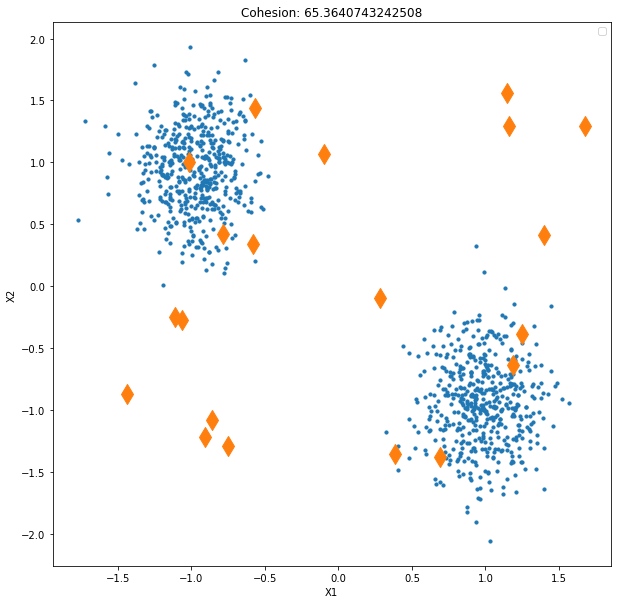

In [22]:
# 새로운 샘플 데이터 시각화
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], s=10) 
plt.scatter(X_new[:,0], X_new[:,1], 
            s=200, marker='d') 
plt.legend(loc='best')
plt.title('Cohesion: ' + str(model_kmeans.inertia_))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [23]:
# 클러스터를 2개로 군집화 학습 및 새로운 데이터 군집화 예측
model_kmeans = KMeans(n_clusters=2, random_state=123, init='k-means++')
model_kmeans.fit(X)
Y_pred = model_kmeans.predict(X_new)
Y_pred

array([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1])

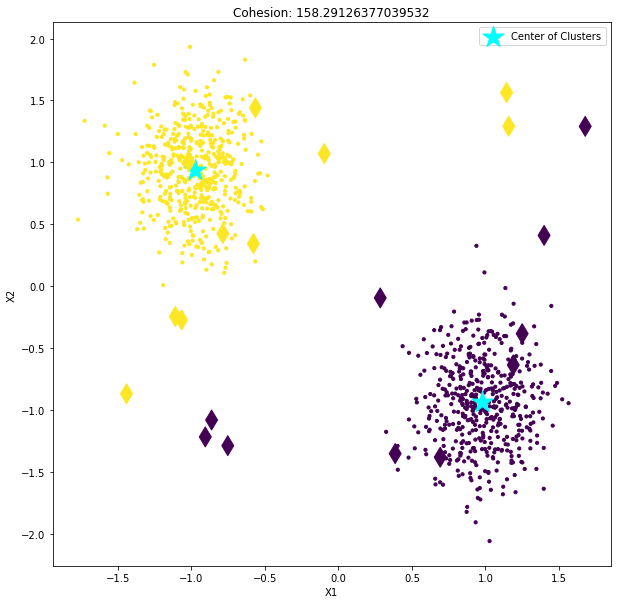

In [24]:
# 예측 군집 시각화
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], 
            s=10, c=model_kmeans.labels_) 
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            marker='*', s=500,
            color='cyan', label='Center of Clusters')
plt.scatter(X_new[:,0], X_new[:,1], 
            s=200, c=Y_pred,
            marker='d') 
plt.legend(loc='best')
plt.title('Cohesion: ' + str(model_kmeans.inertia_))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## K-means 한계

In [25]:
# 클러스터 간의 경계가 직선으로 구분
X, Y = make_blobs(n_samples=200, cluster_std=[1.0, 2.5, 0.5], 
                  centers=3, random_state=170)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
model_kmeans = KMeans(n_clusters=3, random_state=123)
Y_pred = model_kmeans.fit_predict(X)
Y_pred

array([1, 2, 2, 0, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0,
       2, 0, 2, 0, 0, 2, 2, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 0, 1, 1, 2, 1,
       2, 0, 1, 1, 2, 0, 1, 1, 2, 2, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0, 0, 1,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2,
       2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 1, 0, 2, 1, 0, 1,
       1, 1, 2, 1, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 2, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0,
       0, 1])

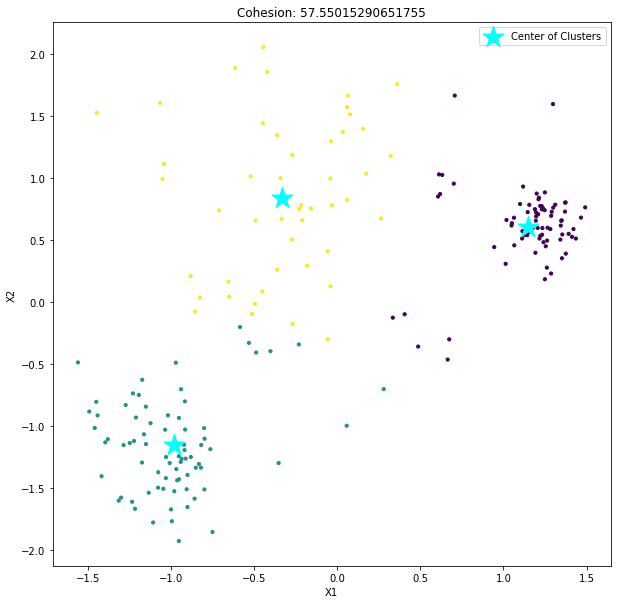

In [26]:
# 클러스터 중심 사이 경계 확인
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], 
            s=10, c=model_kmeans.labels_) 
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            marker='*', s=500,
            color='cyan', label='Center of Clusters')
plt.legend(loc='best')
plt.title('Cohesion: ' + str(model_kmeans.inertia_))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [27]:
# 성능확인
measures_cluster(Y, X, Y_pred)

,Silhouette,ARI,AMI
Score,0.63,0.73,0.74


In [28]:
# 밀도가 다른 클러스터들에서의 군집화
X, Y = make_blobs(n_samples=1000, random_state=170)
transformation = np.random.RandomState(74).normal(size=(2,2))
X = np.dot(X, transformation)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
model_kmeans = KMeans(n_clusters=3, random_state=123)
Y_pred = model_kmeans.fit_predict(X)
Y_pred

array([0, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2,
       2, 0, 0, 2, 2, 2, 1, 0, 1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2,
       2, 1, 0, 1, 2, 1, 1, 2, 2, 2, 2, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 2,
       0, 1, 2, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 0,
       2, 2, 0, 0, 1, 2, 1, 1, 2, 2, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 1, 2,
       0, 2, 0, 2, 1, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1,
       2, 1, 0, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 1,
       2, 0, 0, 1, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 0,
       0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 1, 0, 1, 1,
       1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1,
       0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 1, 1, 0, 1, 2, 2, 2,
       2, 2, 2, 0, 1, 0, 1, 2, 0, 1, 1, 2, 2, 0, 1,

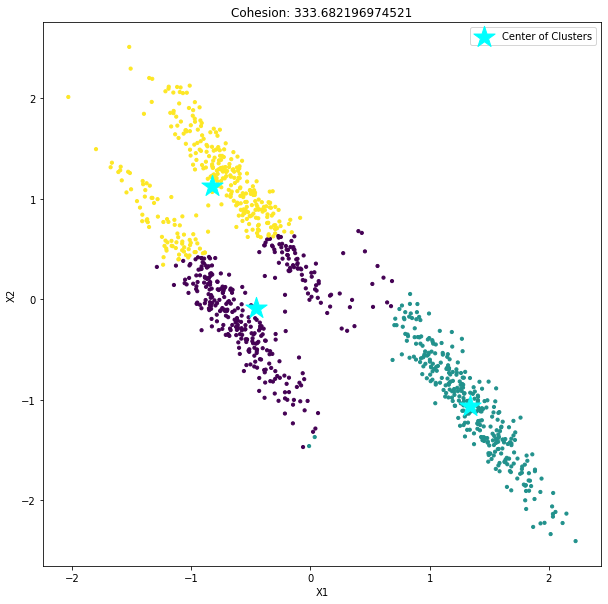

In [29]:
# 클러스터 중심 사이 경계 확인
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], 
            s=10, c=model_kmeans.labels_) 
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            marker='*', s=500,
            color='cyan', label='Center of Clusters')
plt.legend(loc='best')
plt.title('Cohesion: ' + str(model_kmeans.inertia_))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [30]:
# 성능확인
measures_cluster(Y, X, Y_pred)

,Silhouette,ARI,AMI
Score,0.51,0.59,0.61


In [31]:
# 직선 또는 선형이 아닌 경우의 군집화 결과
X, Y = make_moons(n_samples=1000, noise=0.05, random_state=123)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
model_kmeans = KMeans(n_clusters=2, random_state=123)
model_kmeans.fit_predict(X)

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,

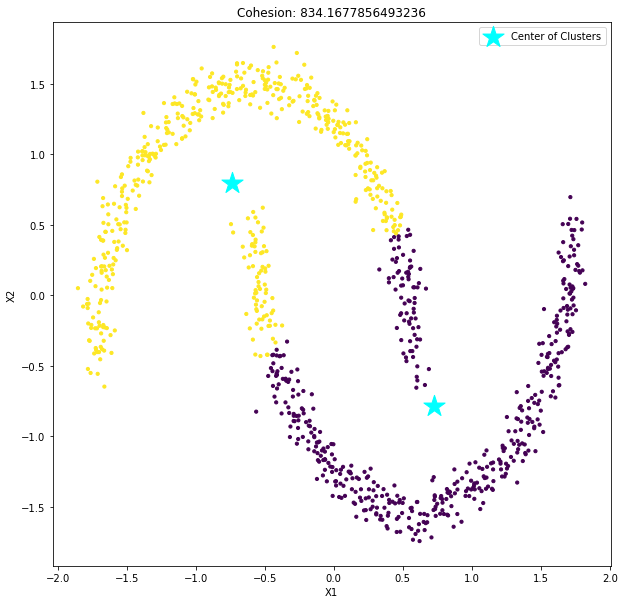

In [32]:
# 클러스터 중심 사이 경계 확인
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], 
            s=10, c=model_kmeans.labels_) 
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            marker='*', s=500,
            color='cyan', label='Center of Clusters')
plt.legend(loc='best')
plt.title('Cohesion: ' + str(model_kmeans.inertia_))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [33]:
# 성능확인
measures_cluster(Y, X, Y_pred)

,Silhouette,ARI,AMI
Score,-0.01,-0.00,-0.00


In [34]:
# 원의 형태라도 고차원 군집화는 효과 떨어짐
X, Y = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=123)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
model_kmeans = KMeans(n_clusters=2, random_state=123)
model_kmeans.fit_predict(X)

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,

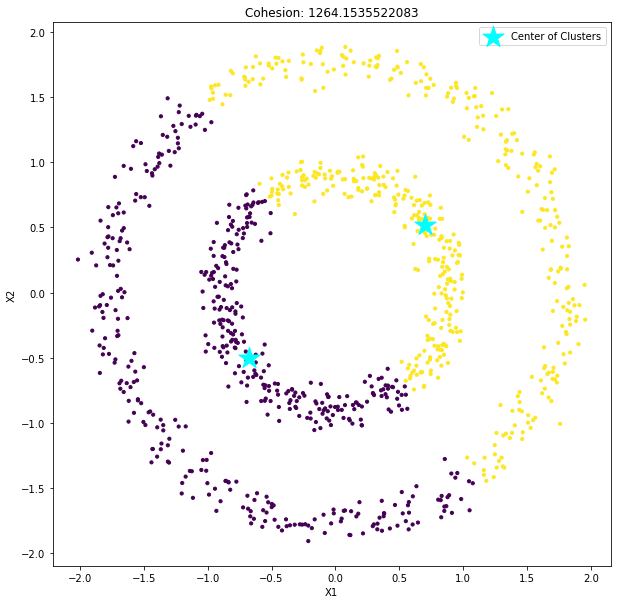

In [35]:
# 클러스터 중심 사이 경계 확인
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], 
            s=10, c=model_kmeans.labels_) 
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            marker='*', s=500,
            color='cyan', label='Center of Clusters')
plt.legend(loc='best')
plt.title('Cohesion: ' + str(model_kmeans.inertia_))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [36]:
# 성능확인
measures_cluster(Y, X, Y_pred)

,Silhouette,ARI,AMI
Score,-0.02,-0.00,-0.00


## 실제 데이터 군집화

### 붓꽃분류 데이터

In [37]:
# 예제 데이터 로딩
iris = load_iris()
columns_origin = ['_'.join(i.split(' (cm)')[0].split(' ')).capitalize() for i in iris.feature_names]
X = pd.DataFrame(iris.data, columns=columns_origin)
Y = iris.target
display(X, pd.DataFrame(Y, columns=['Flower_Name']))

,Sepal_length,Sepal_width,Petal_length,Petal_width
0,5.10,3.50,1.40,0.20
1,4.90,3.00,1.40,0.20
2,4.70,3.20,1.30,0.20
3,4.60,3.10,1.50,0.20
4,5.00,3.60,1.40,0.20
...,...,...,...,...
145,6.70,3.00,5.20,2.30
146,6.30,2.50,5.00,1.90
147,6.50,3.00,5.20,2.00
148,6.20,3.40,5.40,2.30


,Flower_Name
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


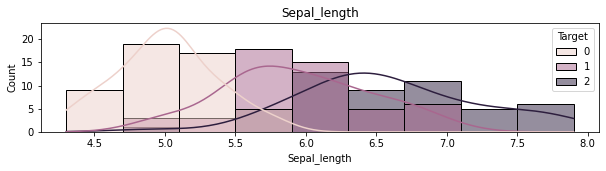

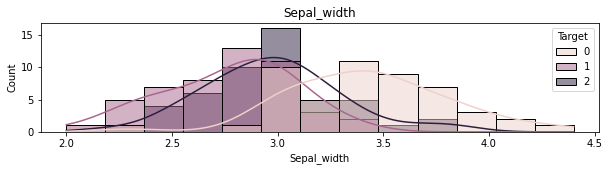

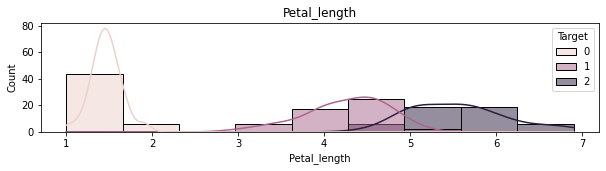

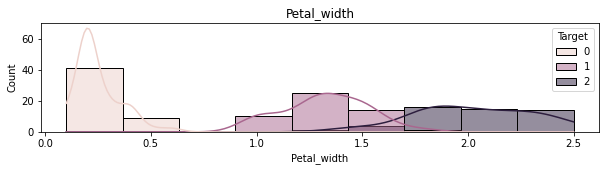

In [38]:
# 변수가 많은 고차원 데이터를 시각화 하는 것은 쉽지 않음
# 분류 여부에 따른 변수별 분포(히스토그램)를 통해 영향력을 확인하는 것이 일반적
for col in X.columns:
    plt.figure(figsize=(10,2))
    sns.histplot(data=pd.concat([pd.DataFrame(Y, columns=['Target']), X], axis=1), 
                 x=col, hue='Target', kde=True)
    plt.title(col)
    plt.show()

In [39]:
# 스케일링
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X).describe()

,0,1,2,3
count,150.00,150.00,150.00,150.00
mean,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-1.87,-2.43,-1.57,-1.45
25%,-0.90,-0.59,-1.23,-1.18
50%,-0.05,-0.13,0.34,0.13
75%,0.67,0.56,0.76,0.79
max,2.49,3.09,1.79,1.71


In [40]:
# 모델링
model_kmeans = KMeans(n_clusters=3, random_state=123)
model_kmeans.fit(X, Y)
Y_pred = model_kmeans.predict(X)
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [41]:
# 성능확인
measures_cluster(Y, X, Y_pred)

,Silhouette,ARI,AMI
Score,0.46,0.62,0.66


In [42]:
# Confusion Matrix 확인
evaluation_class_ConfusionMatrix(Y, Y_pred)

,Pred 0,Pred 1,Pred 2
True 0,0,50,0
True 1,39,0,11
True 2,14,0,36


### 유방암 생존분류 데이터

In [43]:
# 예제 데이터 로딩
# 예측치 라벨링 순서가 어떻게 될지 몰라서 순서를 맞추기 위해 Y라벨을 오름차순으로 정렬
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
Y = pd.DataFrame(cancer.target, columns=['Target'])
df = pd.concat([Y, X], axis=1).sort_values(by='Target').reset_index().iloc[:,1:]
Y = np.ravel(df['Target'])
X = df.iloc[:,1:]
display(X, Y)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,"1,001.00",0.12,0.28,0.30,0.15,0.24,0.08,...,25.38,17.33,184.60,"2,019.00",0.16,0.67,0.71,0.27,0.46,0.12
1,14.22,23.12,94.37,609.90,0.11,0.24,0.20,0.07,0.24,0.08,...,15.74,37.18,106.40,762.40,0.15,0.93,0.85,0.18,0.52,0.14
2,12.34,26.86,81.15,477.40,0.10,0.14,0.11,0.05,0.19,0.07,...,15.65,39.34,101.70,768.90,0.18,0.47,0.44,0.15,0.32,0.12
3,14.86,23.21,100.40,671.40,0.10,0.20,0.17,0.09,0.17,0.07,...,16.08,27.78,118.60,784.70,0.13,0.46,0.46,0.17,0.30,0.09
4,13.77,22.29,90.63,588.90,0.12,0.13,0.14,0.07,0.18,0.07,...,16.39,34.01,111.60,806.90,0.17,0.31,0.38,0.17,0.31,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,10.71,20.39,69.50,344.90,0.11,0.13,0.08,0.03,0.17,0.07,...,11.69,25.21,76.51,410.40,0.13,0.26,0.25,0.09,0.26,0.09
565,12.87,16.21,82.38,512.20,0.09,0.06,0.04,0.02,0.20,0.06,...,13.90,23.64,89.27,597.50,0.13,0.18,0.20,0.06,0.36,0.07
566,13.59,21.84,87.16,561.00,0.08,0.08,0.04,0.02,0.16,0.06,...,14.80,30.04,97.66,661.50,0.10,0.17,0.15,0.06,0.24,0.07
567,11.74,14.02,74.24,427.30,0.08,0.04,0.02,0.03,0.21,0.06,...,13.31,18.26,84.70,533.70,0.10,0.09,0.07,0.08,0.31,0.07


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

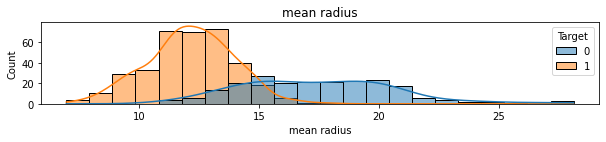

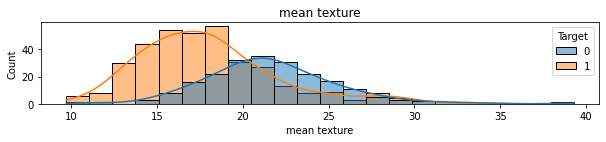

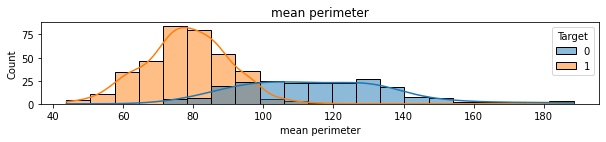

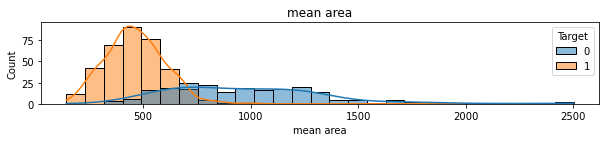

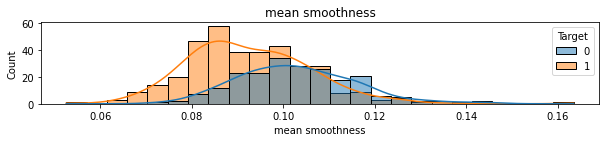

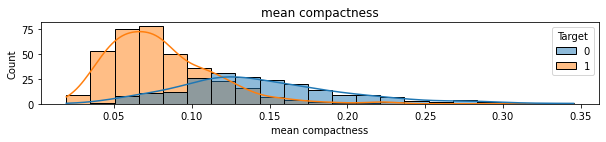

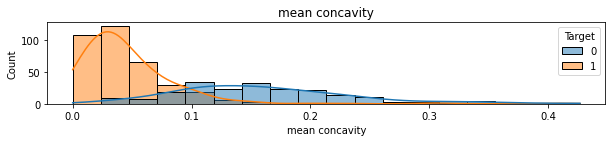

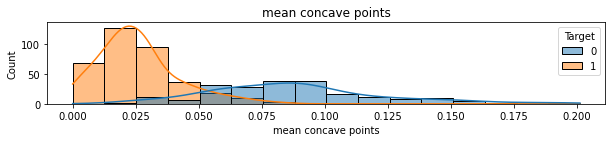

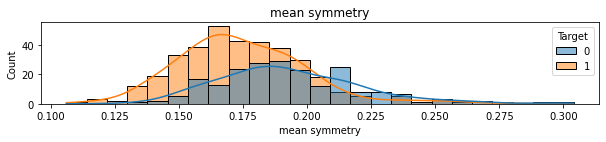

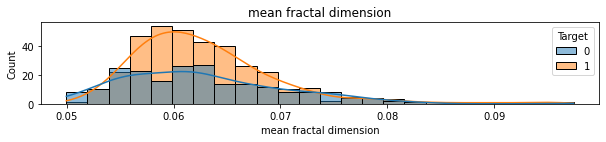

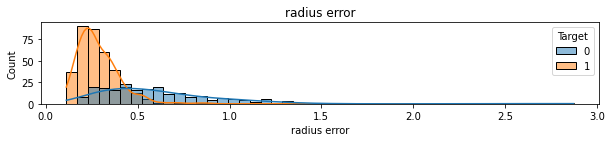

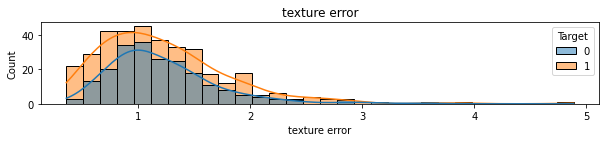

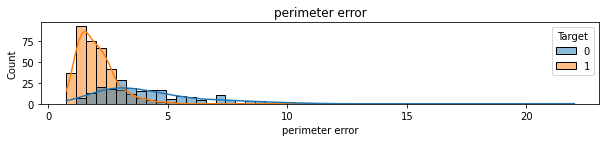

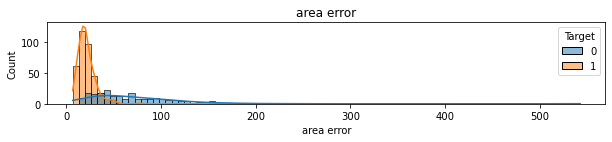

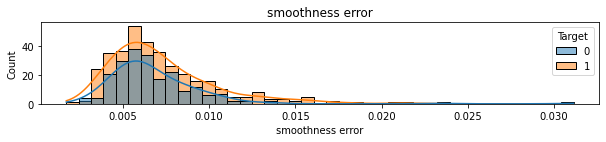

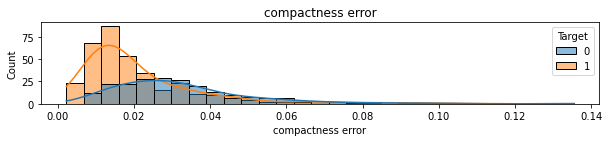

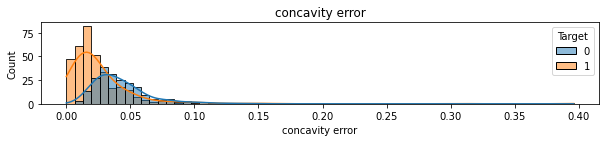

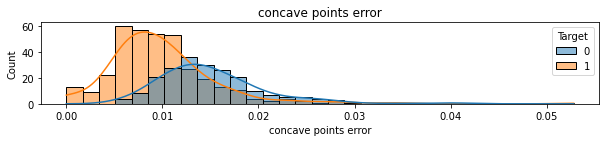

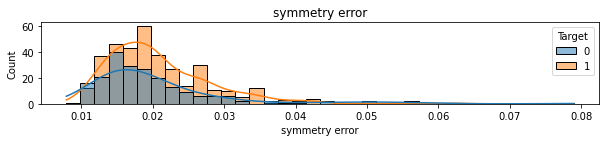

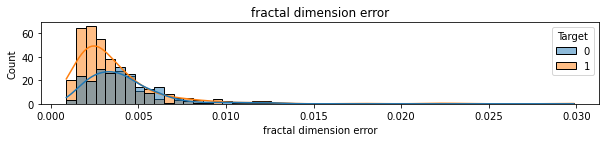

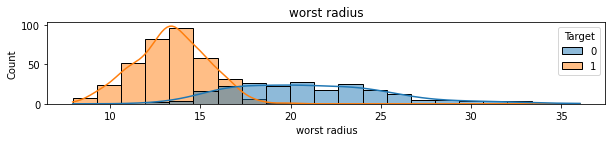

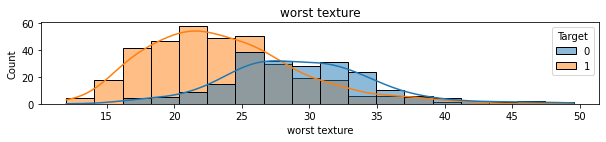

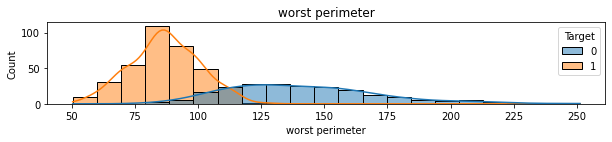

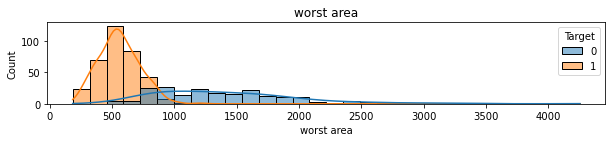

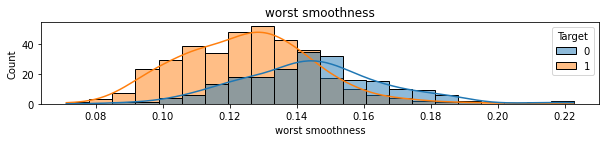

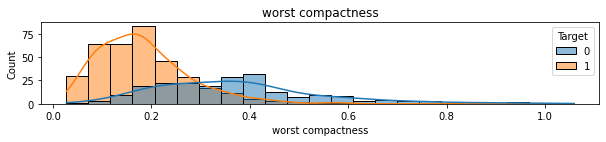

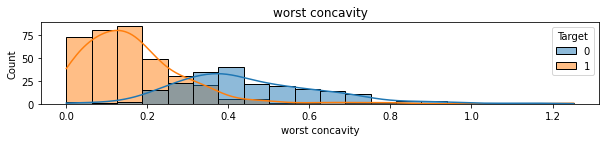

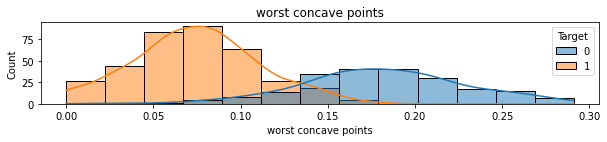

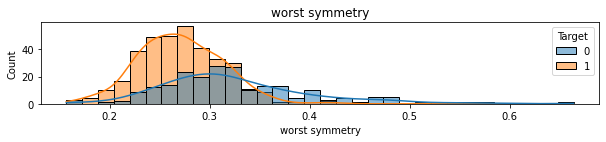

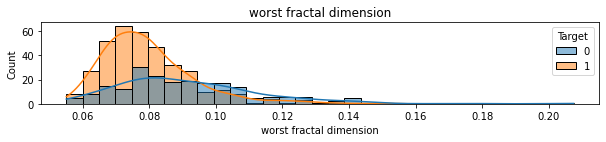

In [44]:
# 변수가 많은 고차원 데이터를 시각화 하는 것은 쉽지 않음
# 분류 여부에 따른 변수별 분포(히스토그램)를 통해 영향력을 확인하는 것이 일반적
for col in X.columns:
    plt.figure(figsize=(10,1.5))
    sns.histplot(data=df, x=col, hue='Target', kde=True)
    plt.title(col)
    plt.show()

In [45]:
# 스케일링
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,...,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
mean,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.03,-2.23,-1.98,-1.45,-3.11,-1.61,-1.11,-1.26,-2.74,-1.82,...,-1.73,-2.22,-1.69,-1.22,-2.68,-1.44,-1.31,-1.75,-2.16,-1.60
25%,-0.69,-0.73,-0.69,-0.67,-0.71,-0.75,-0.74,-0.74,-0.70,-0.72,...,-0.67,-0.75,-0.69,-0.64,-0.69,-0.68,-0.76,-0.76,-0.64,-0.69
50%,-0.22,-0.10,-0.24,-0.30,-0.03,-0.22,-0.34,-0.40,-0.07,-0.18,...,-0.27,-0.04,-0.29,-0.34,-0.05,-0.27,-0.22,-0.22,-0.13,-0.22
75%,0.47,0.58,0.50,0.36,0.64,0.49,0.53,0.65,0.53,0.47,...,0.52,0.66,0.54,0.36,0.60,0.54,0.53,0.71,0.45,0.45
max,3.97,4.65,3.98,5.25,4.77,4.57,4.24,3.93,4.48,4.91,...,4.09,3.89,4.29,5.93,3.96,5.11,4.70,2.69,6.05,6.85


In [46]:
# 모델링
model_kmeans = KMeans(n_clusters=2, random_state=123)
model_kmeans.fit(X, Y)
Y_pred = model_kmeans.predict(X)
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [47]:
# 성능확인
measures_cluster(Y, X, Y_pred)

,Silhouette,ARI,AMI
Score,0.34,0.65,0.53


In [48]:
# Confusion Matrix 확인
evaluation_class_ConfusionMatrix(Y, Y_pred)

,Pred 0,Pred 1
True 0,176,36
True 1,18,339


In [49]:
# Classification Report 확인
evaluation_class_ClassificationReport(Y, Y_pred)

              precision    recall  f1-score   support

     class 0       0.91      0.83      0.87       212
     class 1       0.90      0.95      0.93       357

    accuracy                           0.91       569
   macro avg       0.91      0.89      0.90       569
weighted avg       0.91      0.91      0.90       569



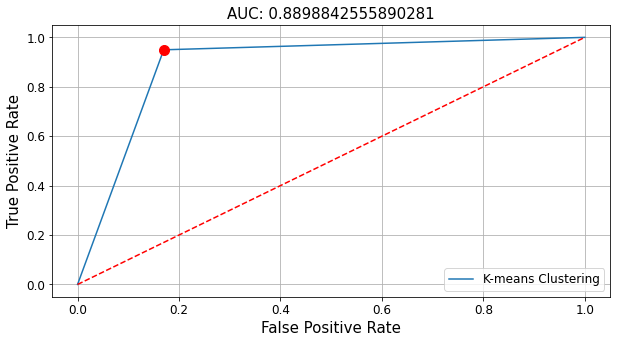

In [50]:
# ROC Curve & AUC 확인
evaluation_class_ROCAUC(Y, Y_pred, label='K-means Clustering')

### 타이타닉 생존분류 데이터

In [51]:
# 타이타닉 생존문제 로딩
from module_classification import *

# 데이터 로딩
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# 데이터 전처리
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)  

scaler = preprocessing.StandardScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

(712, 11) (712, 1)
(179, 11) (179, 1)


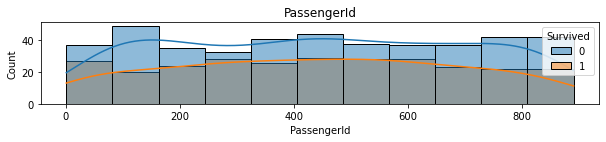

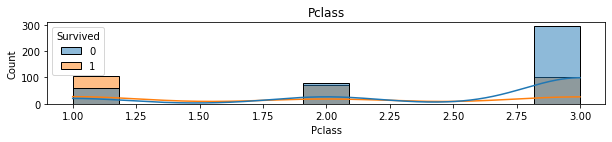

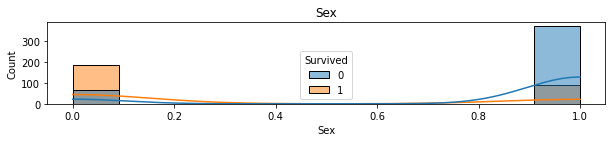

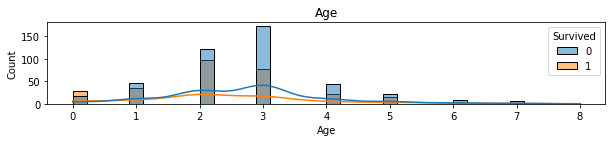

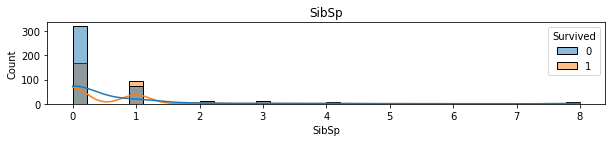

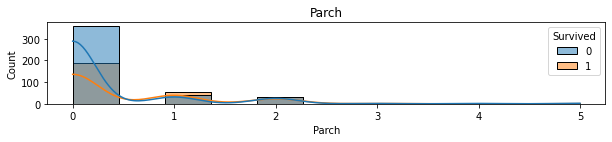

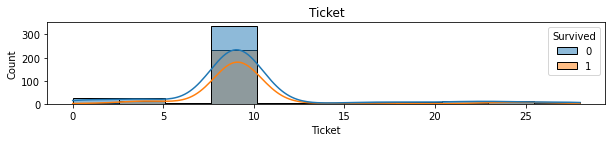

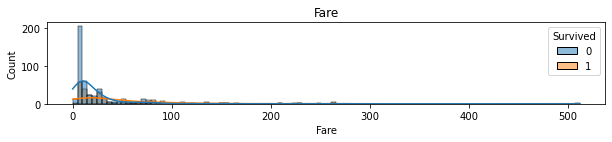

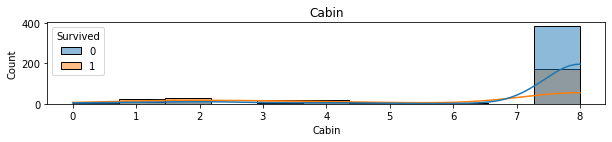

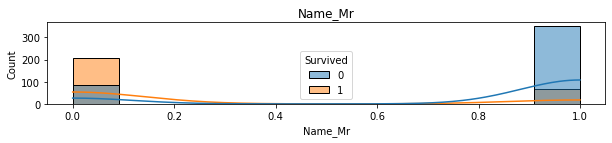

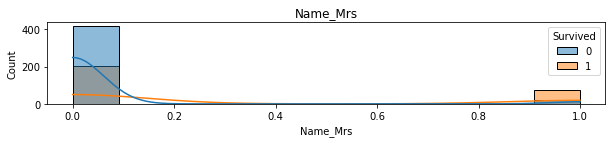

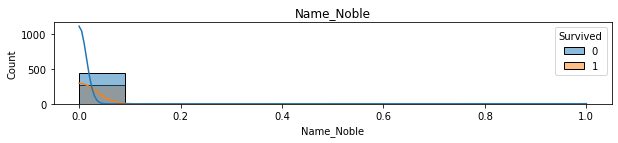

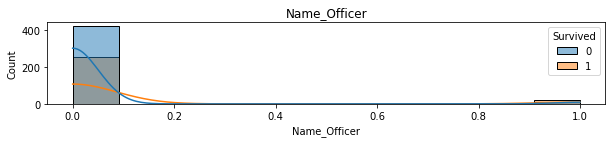

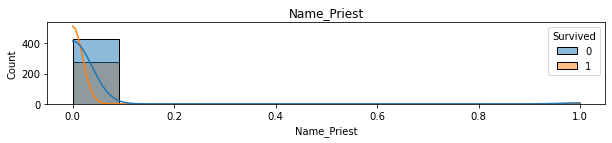

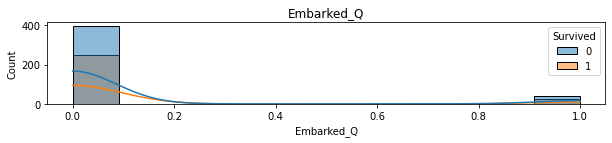

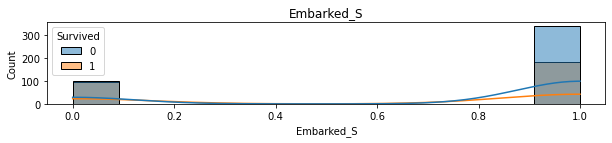

In [52]:
# 변수가 많은 고차원 데이터를 시각화 하는 것은 쉽지 않음
# 분류 여부에 따른 변수별 분포(히스토그램)를 통해 영향력을 확인하는 것이 일반적
for col in X_train_fe.columns:
    plt.figure(figsize=(10,1.5))
    sns.histplot(data=pd.concat([Y_train, X_train_fe], axis=1), x=col, hue=Y_colname[0], kde=True)
    plt.title(col)
    plt.show()

In [53]:
# 모델링
model_kmeans = KMeans(n_clusters=2, random_state=123)
model_kmeans.fit(X_train_fes, Y_train)
Y_trpred = model_kmeans.predict(X_train_fes)
Y_tepred = model_kmeans.predict(X_test_fes)

In [54]:
# Train 성능확인
measures_cluster(np.ravel(Y_train), X_train_fes, Y_trpred)

,Silhouette,ARI,AMI
Score,0.23,0.32,0.23


In [55]:
# Confusion Matrix 확인
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)

,Pred 0,Pred 1
True 0,349,86
True 1,68,209


In [56]:
# Test 성능확인
measures_cluster(np.ravel(Y_test), X_test_fes, Y_tepred)

,Silhouette,ARI,AMI
Score,0.21,0.31,0.24


In [57]:
# Confusion Matrix 확인
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

,Pred 0,Pred 1
True 0,88,26
True 1,13,52


In [58]:
# Classification Report 확인
evaluation_class_ClassificationReport(Y_train, Y_trpred)
evaluation_class_ClassificationReport(Y_test, Y_tepred)

              precision    recall  f1-score   support

     class 0       0.84      0.80      0.82       435
     class 1       0.71      0.75      0.73       277

    accuracy                           0.78       712
   macro avg       0.77      0.78      0.78       712
weighted avg       0.79      0.78      0.78       712

              precision    recall  f1-score   support

     class 0       0.87      0.77      0.82       114
     class 1       0.67      0.80      0.73        65

    accuracy                           0.78       179
   macro avg       0.77      0.79      0.77       179
weighted avg       0.80      0.78      0.79       179



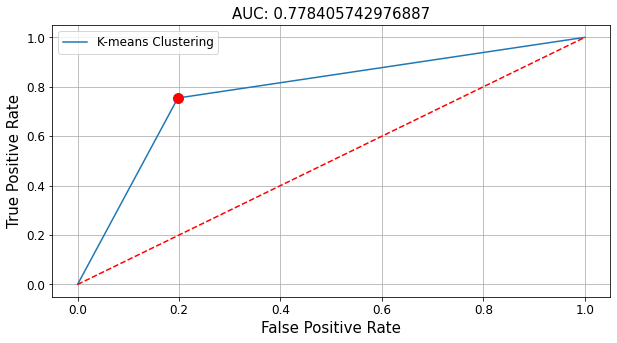

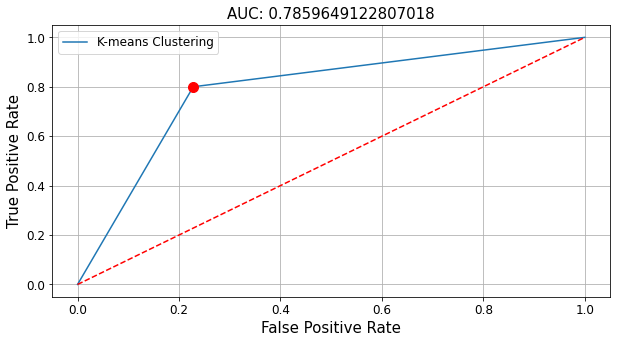

In [59]:
# ROC Curve & AUC 확인
evaluation_class_ROCAUC(Y_train, Y_trpred, label='K-means Clustering')
evaluation_class_ROCAUC(Y_test, Y_tepred, label='K-means Clustering')

# **Applying Base Algorithm:** Principal Component Analysis

**3) 주성분 분석(Principal Component Analysis, PCA):** 최적의 `차원/변수 조합`을 찾아 `변수선택 및 차원축소` 방법론 중 하나

- **원리:** 모든 차원의 특성을 `최대로 유지`하면서 원데이터의 `손실을 최소화` 하기 위해 `높은 분산을 갖는 기저(Basis)`를 찾아 `차원축소`

> **"비수학적(기하학적)":** 데이터의 특성을 잘 표현하는 `데이터의 차원(주성분)`을 뽑아 `데이터의 양`을 줄이는 것
>
> (1) 데이터의 특징을 잘 표현(분산이 큰)하는 `주축(Principle)`을 찾음
>
> (2) 주축으로  데이터를 `차원변환`한 상태에서 분산이 큰 `성분축(Componemt)`을 찾음
> 
> (3) `성분축`을 기준으로 (2)를 지속 반복하여 `변수의 갯수`만큼의 모든 `주축+성분축` 찾음
>
> (4) `변수의 갯수`보다 적은 `주축+성분축`만 골라 최종 `차원변환 행렬` 생성
>
> (5) `최종 차원변환 행렬`에 데이터를 곱하여 `새로운 저차원 데이터` 생성
>
> <center><img src='Image/Advanced/PCA_2D_Projection1.png' width='500'></center>
>
> <center><img src='Image/Advanced/PCA_2D_Projection2.png' width='600'>(https://tyami.github.io/machine%20learning/PCA/)</center>
>
<!-- > <center><img src='Image/Advanced/PCA_2DFinal.png' width='800'>(https://subinium.github.io/MLwithPython-3-4/)</center> -->
>
> <center><img src='Image/Advanced/PCA_2D_Ex.png' width='800'>(https://www.mdpi.com/2076-3417/11/9/3780)</center>

> **"수학적":** 변수들 간에 존재하는 `분산(상관관계)`를 이용하여 `주성분`을 추출하면서 차원을 축소하는 기법
>
> (1) 데이터의 `표준화/정규화`하여 `크기를 조정`하고 평균으로 `원점을 옮김`
>
> $$
\begin{aligned}
X_{s} = \frac{X - \mu}{\sigma}
\end{aligned}
$$
>
> (2) 데이터의 `공분산 행렬` 계산
>
> - **공분산(Covariance):** `2개 이상`의 변수들의 `상관관계`
> - 공분산은 `변수의 수`에 따라 `증가`하기 때문에, `변수의 수`로 나눔
>
> $$
\begin{aligned}
Cov(X_{s}) = \frac{1}{n - 1} X_{s}^{T} X_{s}
\end{aligned}
$$
>
> (3) `공분산 행렬`에서 `SVD`를 사용하여 `고유벡터 및 고유값` 추정
>
<!-- > $$
\begin{aligned}
X_{s} &= U \Sigma V^{T} \\
& \text{where } A \text{ is } m \times n \text{ matrix } (m \times n), \\
& U \text{ is } m \times m \text{ eigenvector matrix of } X_{s} \times X_{s}^{T}, \\
& V \text{ is } n \times n \text{ eigenvector matrix of } X_{s}^{T} \times X_{s}, \\
& \text{and } \Sigma \text{ is } m \times n \text{ diagonal matrix with eigenvalues } \sqrt{\lambda_{i}}.
\end{aligned}
$$ -->
>
> (4) `고유값`이 큰 순서대로 `정렬`
>
> - `고유값`이 가장 큰 경우의 `고유벡터`는 데이터에서 `가장 큰 분산을 가진 기저(Basis)`
> - `고유값` = `고유벡터의 크기` = `데이터의 분산`
> - 고유값의 크기만큼의 `변수의 분산 크기`
> - `고유값의 수` = `고유벡터의 수` = `차원/변수의 수`
> - 변수의 수만큼의 `고유값/고유벡터` 
>
> $$
\begin{aligned}
V =  \begin{bmatrix} \vec{v}_1, \vec{v}_2, \vec{v}_3, ...\end{bmatrix} 
\end{aligned}
$$
> - $\vec{v}_1$이 가장 분산이 큰 고유벡터, $\vec{v}_2$는 다음으로 분산이 큰 고유벡터
> - $\vec{v}_1, \vec{v}_2, \vec{v}_3, ...$는 `서로 독립`이며 공간상에서는 `직각`으로 표현됨
>
> (5) 지정된 `최소 분산 크기 이상`을 설명하도록, `k(변수의 수보다 작은)`번째 `고유벡터`까지 선택
>
> $$
\begin{aligned}
Var(X_{s}) & \simeq Var(X_{s,k}) \\
& = Var(X_{s,1}) + Var(X_{s,2}) + ... + Var(X_{s,k}) \\
& = \lambda_{1} + \lambda_{2} + ... + \lambda_{k}
\end{aligned}
$$
>
> - **PVE(Proportion of Variance Explained):** `주성분들`의 `분산 비율`
> - 일반적으로 모든 주성분을 사용하지 않고, `처음 몇개`의 주성분만 사용
> - `몇개의 주성분이 필요한지` `Scree Plot` 시각화하고 `총합은 100%`
> - `적은 변수` 일수록 좋고 `많은 분산`을 커버할수록 좋음
> - 누적 분산의 기울기가 급변하는 지점을 흔히 `Elbow(팔꿈치)`라고 함
>
> $$
\begin{aligned}
\frac{\sum_{j=1}^{k} \lambda_{j}}{\sum_{j=1}^{n} \lambda_{j}} = 90 \% ?
\end{aligned}
$$
>
> <center><img src='Image/Advanced/PCA_ScreePlot1.png' width='800'>(https://www.researchgate.net/figure/Principal-components-analysis-scree-plot_fig2_350281842)</center>
>
> <center><img src='Image/Advanced/PCA_ScreePlot2.png' width='800'>(https://bioconductor.org/packages/devel/bioc/vignettes/PCAtools/inst/doc/PCAtools.html)</center>
>
> (6) `원데이터`에 `선택된 고유벡터 행렬`로 차원변환을 하면 `새로운 저차원 데이터`
>
> <center><img src='Image/Advanced/PCA_Visualization.png' width='800'></center>

---

<center><img src='Image/Advanced/PCA_MultiEx.png' width='800'></center>
<center><img src='Image/Advanced/PCA_MultiExPC1PC2.png' width='500'>(https://www.mdpi.com/2076-3417/11/9/3780)</center>

---

- **정리:** 모든 차원의 특성을 `최대로 유지`하면서 원데이터의 `손실을 최소화` 하기 위해 `높은 분산을 갖는 기저(Basis)`를 찾아 `차원축소`

> - `데이터의 분포 특성`은 일반적으로 평균과 분산 등이 있는데, PCA는 데이터의 퍼진 정도인 `분산(상관관계)` 사용
> - 차원축소시 `벡터와 행렬 연산`, 최대화 분산 파악을 위한 `고유값, 고유벡터, 공분산, 라그랑주승수 등` 여러가지 `선형대수 이론` 활용
> - `원데이터`의 `분포 특성`을 유지한 채, `차원 축소`하는 기법으로 `특이값 분해(SVD)`방법론 사용
>
> **(1) Full SVD:**
>
> <center><img src='Image/Advanced/SVD_Full.png' width='600'></center>
>
> **(4) Truncated SVD:** $\Sigma$에서 `비대각파트` , `0인 고유값 대각파트` 뿐만 아니라 `0이 아닌 고유값 대각파트`도 제거한 형태 (`A 변경되어 원래의 A 복원 불가!`)
>
> <center><img src='Image/Advanced/SVD_Truncated.png' width='500'>(https://darkpgmr.tistory.com/106)</center>

- **장단점:**

> **"장점"**
>
> - 데이터의 차원/변수의 수가 `크면` 데이터를 한눈에 `인식하기 어려운데`, PCA가 `도움`
> - 데이터의 `주요한 특징을 추출`하기 때문에 `지도학습`을 위한 `전처리, 시각화`의 도구로도 많이 사용
> - 많은 양의 정보를 `효과적`으로 `시각화` 가능
> - 독립변수들이 독립적이지 않아 발생하는 `다중공선성(Multicollinearity)`를 해결하는데 기여
> - 데이터 `저장공간 확보` 및 `전송효율`과 `연산속도` 유리
>
> **"단점"**
>
> - 알고리즘으로서 예측하여 `성능 검증`이 어려워 이보다 `데이터 특성 확인`에 많이 사용
> - 원데이터 대비 정도의 차이일 뿐 필연적으로 `정보 손실`이 발생
> - 변환된 데이터가 `무슨의미인지? 무슨값인지?` 해석의 어려움
> - `공분산`이 중요한 기준이기 때문에, `분산이 작은게 좋은 데이터`에서는 `부적합`
> - 데이터 분산이 `직교`하지 않으면 부적합 = 데이터 변수가 `독립`이 아니면 부적합

## Principal Component Analysis 추정

In [60]:
# 예제 데이터 로딩
iris = load_iris()
columns_origin = ['_'.join(i.split(' (cm)')[0].split(' ')).capitalize() for i in iris.feature_names]
X = pd.DataFrame(iris.data, columns=columns_origin)
Y = pd.DataFrame(iris.target, columns=['Target'])
df = pd.concat([Y, X], axis=1)
df

,Target,Sepal_length,Sepal_width,Petal_length,Petal_width
0,0,5.10,3.50,1.40,0.20
1,0,4.90,3.00,1.40,0.20
2,0,4.70,3.20,1.30,0.20
3,0,4.60,3.10,1.50,0.20
4,0,5.00,3.60,1.40,0.20
...,...,...,...,...,...
145,2,6.70,3.00,5.20,2.30
146,2,6.30,2.50,5.00,1.90
147,2,6.50,3.00,5.20,2.00
148,2,6.20,3.40,5.40,2.30


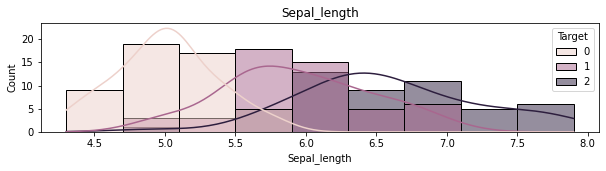

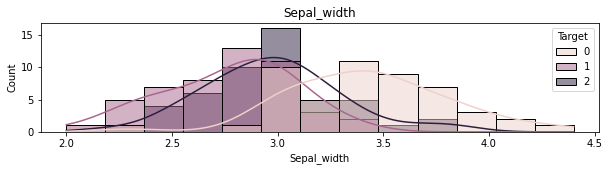

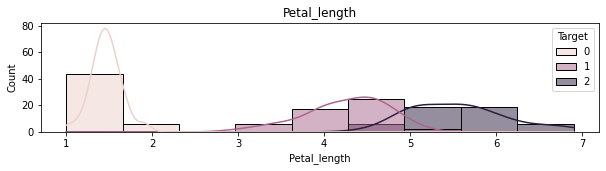

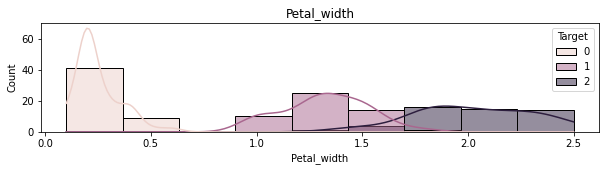

In [61]:
# 변수가 많은 고차원 데이터를 시각화 하는 것은 쉽지 않음
# 분류 여부에 따른 변수별 분포(히스토그램)를 통해 영향력을 확인하는 것이 일반적
for col in X.columns:
    plt.figure(figsize=(10,2))
    sns.histplot(data=pd.concat([pd.DataFrame(Y, columns=['Target']), X], axis=1), 
                 x=col, hue='Target', kde=True)
    plt.title(col)
    plt.show()

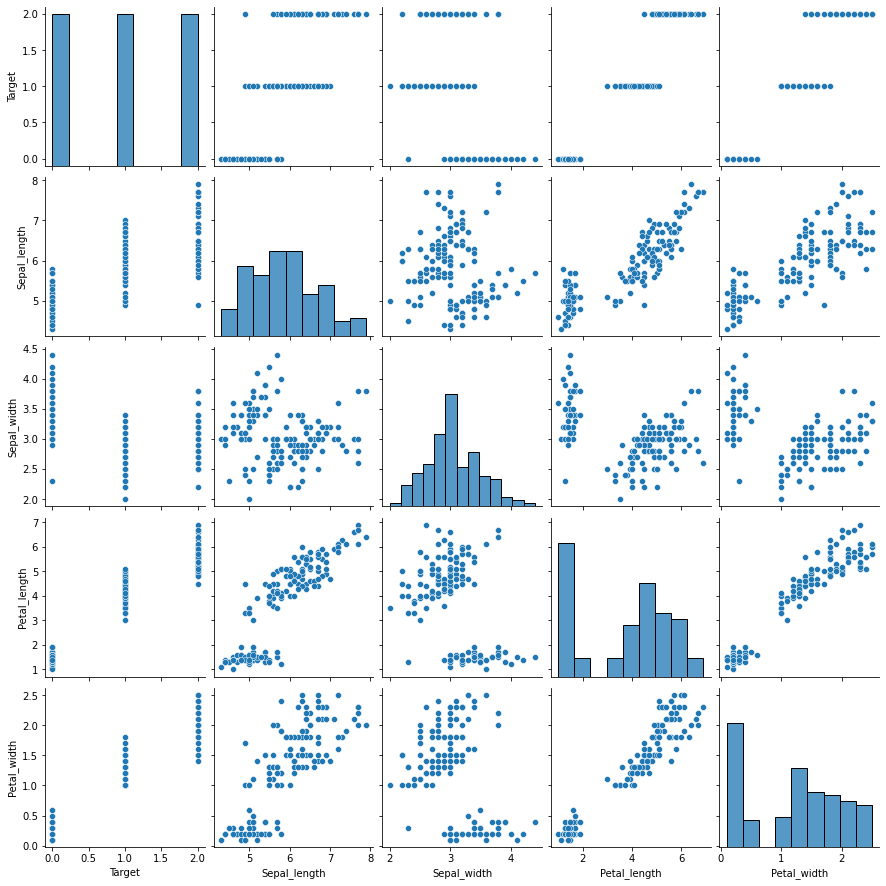

In [62]:
# seaborn 함수를 sns로 사용하여 pairplot 그리기
sns.pairplot(df)
plt.show()

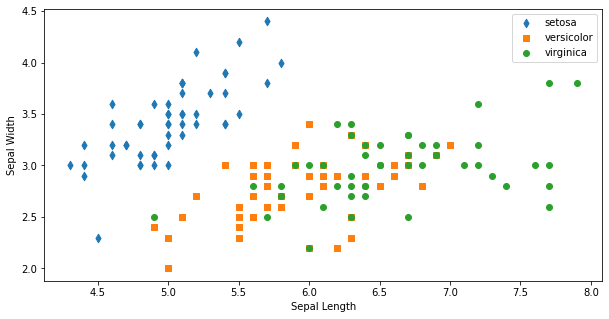

In [63]:
# Target에 따른 퍼진정도 확인
plt.figure(figsize=(10,5))

markers = ['d','s','o']
for i, marker in enumerate(markers):
    X_sub = df[df['Target']==i]['Sepal_length']
    Y_sub = df[df['Target']==i]['Sepal_width']
    plt.scatter(X_sub, Y_sub, marker=marker, label=iris.target_names[i])
    
plt.legend()
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

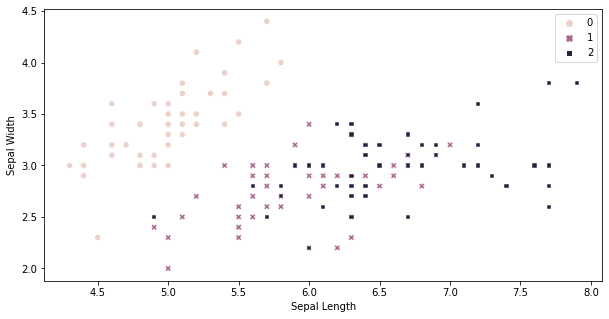

In [64]:
# Target에 따른 퍼진정도 확인
plt.figure(figsize=(10,5))
sns.scatterplot(x='Sepal_length', y='Sepal_width', data=df, 
                hue='Target', style='Target')
plt.legend()
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

In [65]:
# 스케일링
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X).describe()

,0,1,2,3
count,150.00,150.00,150.00,150.00
mean,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-1.87,-2.43,-1.57,-1.45
25%,-0.90,-0.59,-1.23,-1.18
50%,-0.05,-0.13,0.34,0.13
75%,0.67,0.56,0.76,0.79
max,2.49,3.09,1.79,1.71


In [66]:
# 4차원의 데이터의 주성분 추출
model_pca = PCA(n_components=4)
model_pca.fit(X)
X_pca = model_pca.transform(X)
X_pca

array([[-2.26470281e+00,  4.80026597e-01, -1.27706022e-01,
        -2.41682039e-02],
       [-2.08096115e+00, -6.74133557e-01, -2.34608854e-01,
        -1.03006775e-01],
       [-2.36422905e+00, -3.41908024e-01,  4.42014848e-02,
        -2.83770534e-02],
       [-2.29938422e+00, -5.97394508e-01,  9.12901063e-02,
         6.59555596e-02],
       [-2.38984217e+00,  6.46835383e-01,  1.57381957e-02,
         3.59228133e-02],
       [-2.07563095e+00,  1.48917752e+00,  2.69682944e-02,
        -6.60818022e-03],
       [-2.44402884e+00,  4.76441976e-02,  3.35470401e-01,
         3.67755572e-02],
       [-2.23284716e+00,  2.23148073e-01, -8.86954979e-02,
         2.46120962e-02],
       [-2.33464048e+00, -1.11532768e+00,  1.45076864e-01,
         2.68592208e-02],
       [-2.18432817e+00, -4.69013561e-01, -2.53765567e-01,
         3.98992877e-02],
       [-2.16631010e+00,  1.04369065e+00, -2.68681102e-01,
        -1.67313672e-02],
       [-2.32613087e+00,  1.33078335e-01,  9.37592444e-02,
      

In [67]:
# 고유값 순위 = 데이터 설명 분산의 크기
model_pca.explained_variance_

array([2.93808505, 0.9201649 , 0.14774182, 0.02085386])

In [68]:
# 고유값 순위 = 데이터 설명 분산의 크기
colnames = ['PC'+str(i) for i in range(1, X_pca.shape[1]+1)]
pd.DataFrame(model_pca.explained_variance_, index=colnames, columns=['Proportion of Variance']).T

,PC1,PC2,PC3,PC4
Proportion of Variance,2.94,0.92,0.15,0.02


In [69]:
# 데이터 설명 분산의 누적 크기
colnames = ['PC'+str(i) for i in range(1, X_pca.shape[1]+1)]
pd.DataFrame(np.cumsum(model_pca.explained_variance_), 
             index=colnames, columns=['Proportion of Variance']).T

,PC1,PC2,PC3,PC4
Proportion of Variance,2.94,3.86,4.01,4.03


In [70]:
# 고유벡터 = 데이터 분산을 최대화 하는 방향
model_pca.components_.T

array([[ 0.52106591,  0.37741762, -0.71956635, -0.26128628],
       [-0.26934744,  0.92329566,  0.24438178,  0.12350962],
       [ 0.5804131 ,  0.02449161,  0.14212637,  0.80144925],
       [ 0.56485654,  0.06694199,  0.63427274, -0.52359713]])

In [71]:
# 고유벡터 = 데이터 분산을 최대화 하는 방향
pd.DataFrame(model_pca.components_.T, columns=colnames, index=columns_origin)

,PC1,PC2,PC3,PC4
Sepal_length,0.52,0.38,-0.72,-0.26
Sepal_width,-0.27,0.92,0.24,0.12
Petal_length,0.58,0.02,0.14,0.80
Petal_width,0.56,0.07,0.63,-0.52


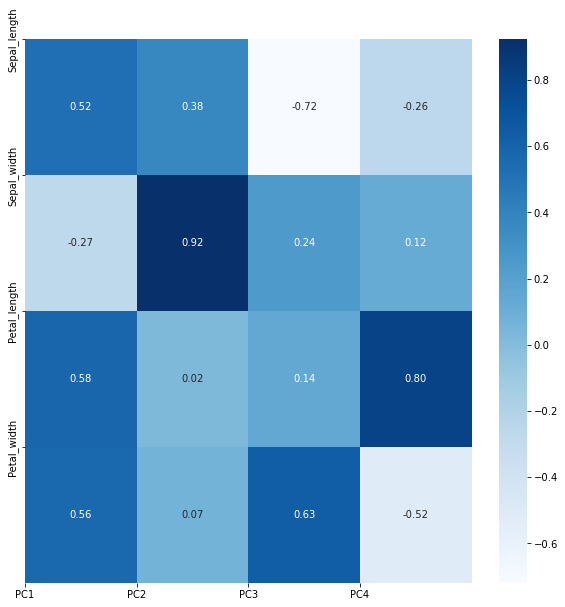

In [72]:
# 고유벡터 시각화 및 변수별 이해
plt.figure(figsize=(10,10))
sns.heatmap(model_pca.components_.T, cmap='Blues', annot=True, fmt='.2f')
plt.xticks([i for i in range(X_pca.shape[1])], colnames)
plt.yticks([i for i in range(X_pca.shape[1])], columns_origin)
plt.show()

In [73]:
# 고유값 순위 = 데이터 설명 분산의 비율
model_pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

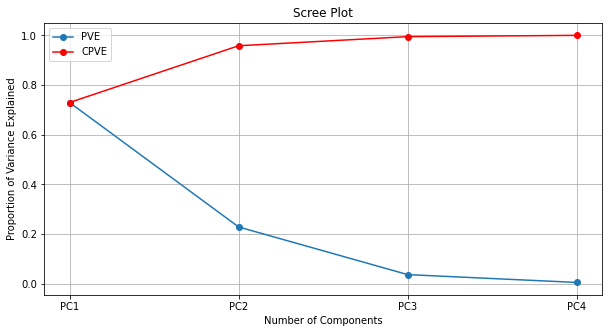

In [74]:
# Scree Plot
plt.figure(figsize=(10,5))
plt.plot(model_pca.explained_variance_ratio_, 'o-', label='PVE')
plt.plot(model_pca.explained_variance_ratio_.cumsum(), 'o-', c='red', label='CPVE')
plt.legend()
plt.title('Scree Plot')
plt.xticks(ticks=list(range(X_pca.shape[1])), labels=colnames)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

In [75]:
# 주성분 데이터 정리
colnames = ['PC'+str(i) for i in range(1, X_pca.shape[1]+1)]
X_pca = pd.DataFrame(X_pca, columns=colnames)
df_pca = pd.concat([Y, X_pca], axis=1)
df_pca

,Target,PC1,PC2,PC3,PC4
0,0,-2.26,0.48,-0.13,-0.02
1,0,-2.08,-0.67,-0.23,-0.10
2,0,-2.36,-0.34,0.04,-0.03
3,0,-2.30,-0.60,0.09,0.07
4,0,-2.39,0.65,0.02,0.04
...,...,...,...,...,...
145,2,1.87,0.39,0.26,-0.39
146,2,1.56,-0.90,-0.03,-0.22
147,2,1.52,0.27,0.18,-0.12
148,2,1.37,1.01,0.93,-0.03


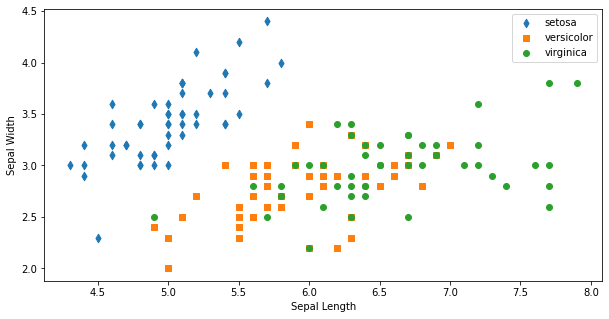

In [76]:
# 원데이터의 Target에 따른 퍼진정도 확인
plt.figure(figsize=(10,5))

markers = ['d','s','o']
for i, marker in enumerate(markers):
    X_sub = df[df['Target']==i]['Sepal_length']
    Y_sub = df[df['Target']==i]['Sepal_width']
    plt.scatter(X_sub, Y_sub, marker=marker, label=iris.target_names[i])
    
plt.legend()
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

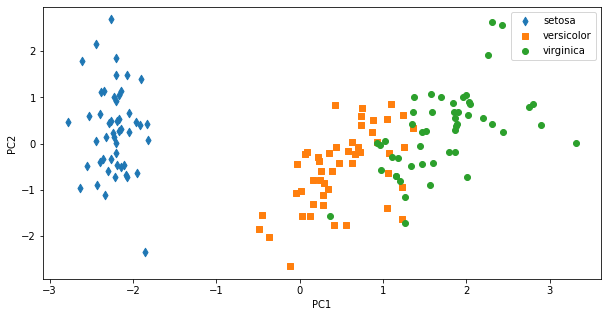

In [77]:
# 차원변환 후 Target에 따른 퍼진정도 확인
plt.figure(figsize=(10,5))

markers = ['d','s','o']
for i, marker in enumerate(markers):
    X_sub = df_pca[df_pca['Target']==i]['PC1']
    Y_sub = df_pca[df_pca['Target']==i]['PC2']
    plt.scatter(X_sub, Y_sub, marker=marker, label=iris.target_names[i])
    
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [78]:
# 시각화 외장함수 설치 및 로딩
# PC 환경에 따라 설치 및 실행이 불가할 수 있음
!conda install -c bioconda bioinfokit --yes
!pip install matplotlib-venn
!pip install adjustText
!pip install textwrap3

from bioinfokit.visuz import cluster

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


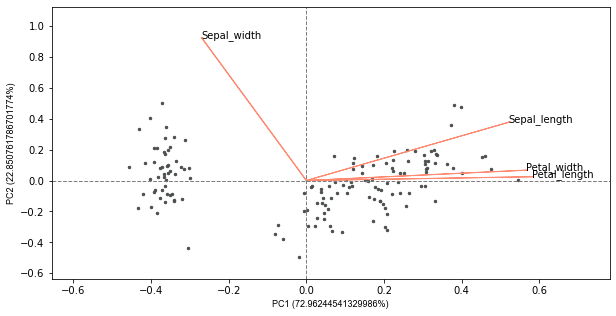

In [79]:
# 차원변환 후 Target에 따른 퍼진정도 확인
# 각 샘플에 따른 색상 표현도 colorlist 파라미터로 가능한데, 최신 버전이 아닐시 불가할 수 있음
cluster.biplot(cscore=X_pca.values, loadings=model_pca.components_, labels=columns_origin,
               var1=model_pca.explained_variance_ratio_[0]*100,
               var2=model_pca.explained_variance_ratio_[1]*100,
               show=True, dim=(10,5))

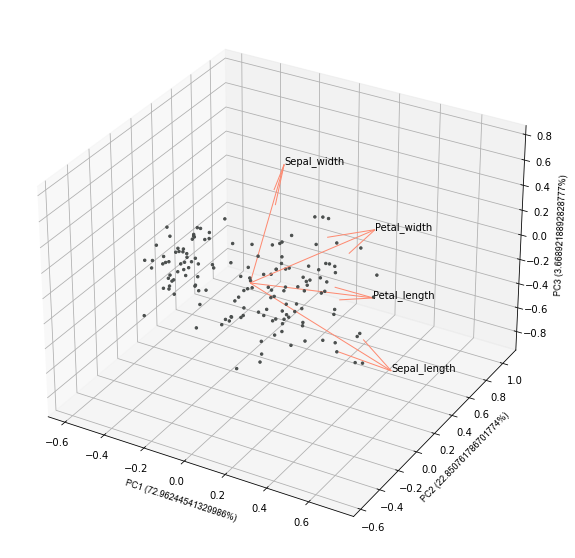

In [80]:
# 차원변환 후 Target에 따른 퍼진정도 확인
# 각 샘플에 따른 색상 표현도 colorlist 파라미터로 가능한데, 최신 버전이 아닐시 불가할 수 있음
cluster.biplot(cscore=X_pca.values, loadings=model_pca.components_, labels=columns_origin,
               var1=model_pca.explained_variance_ratio_[0]*100,
               var2=model_pca.explained_variance_ratio_[1]*100,
               var3=model_pca.explained_variance_ratio_[2]*100,
               show=True, dim=(10,10))

## 실제 데이터 차원변환

### 붓꽃분류 데이터

In [81]:
# 예제 데이터 로딩
iris = load_iris()
columns_origin = ['_'.join(i.split(' (cm)')[0].split(' ')).capitalize() for i in iris.feature_names]
X = pd.DataFrame(iris.data, columns=columns_origin)
Y = iris.target

# 스케일링
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# 모델링
model_kmeans = KMeans(n_clusters=3, random_state=123)
model_kmeans.fit(X, Y)
Y_pred = model_kmeans.predict(X)

# 성능확인
display(measures_cluster(Y, X, Y_pred))

# Confusion Matrix 확인
evaluation_class_ConfusionMatrix(Y, Y_pred)

,Silhouette,ARI,AMI
Score,0.46,0.62,0.66


,Pred 0,Pred 1,Pred 2
True 0,0,50,0
True 1,39,0,11
True 2,14,0,36


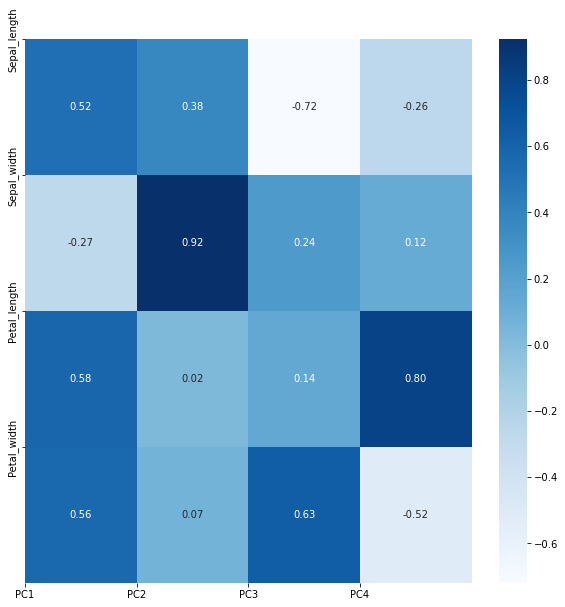

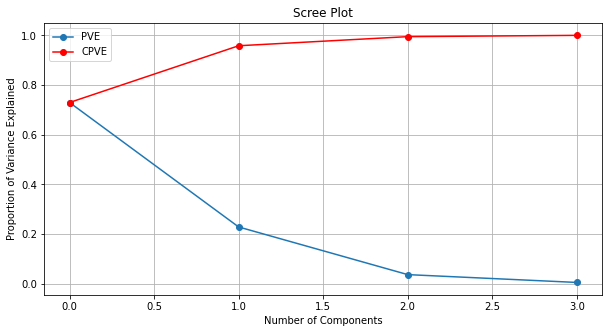

,PC1,PC2,PC3,PC4
0,-2.26,0.48,-0.13,-0.02
1,-2.08,-0.67,-0.23,-0.10
2,-2.36,-0.34,0.04,-0.03
3,-2.30,-0.60,0.09,0.07
4,-2.39,0.65,0.02,0.04
...,...,...,...,...
145,1.87,0.39,0.26,-0.39
146,1.56,-0.90,-0.03,-0.22
147,1.52,0.27,0.18,-0.12
148,1.37,1.01,0.93,-0.03


In [82]:
# 예제 데이터 로딩
iris = load_iris()
columns_origin = ['_'.join(i.split(' (cm)')[0].split(' ')).capitalize() for i in iris.feature_names]
X = pd.DataFrame(iris.data, columns=columns_origin)
Y = pd.DataFrame(iris.target, columns=['Target'])

# 스케일링
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# 데이터의 주성분 추출
model_pca = PCA(n_components=X.shape[1])
model_pca.fit(X)
X_pca = model_pca.transform(X)

# 고유벡터 시각화 및 변수별 이해
plt.figure(figsize=(10,10))
sns.heatmap(model_pca.components_.T, cmap='Blues', annot=True, fmt='.2f')
colnames = ['PC'+str(i) for i in range(1, X_pca.shape[1]+1)]
plt.xticks([i for i in range(X_pca.shape[1])], colnames)
plt.yticks([i for i in range(X_pca.shape[1])], columns_origin)
plt.show()

# Scree Plot
plt.figure(figsize=(10,5))
plt.plot(model_pca.explained_variance_ratio_, 'o-', label='PVE')
plt.plot(model_pca.explained_variance_ratio_.cumsum(), 'o-', c='red', label='CPVE')
plt.legend()
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

# 주성분 데이터 정리
colnames = ['PC'+str(i) for i in range(1, X_pca.shape[1]+1)]
X_pca = pd.DataFrame(X_pca, columns=colnames)
X_pca

In [83]:
# 데이터의 분포 통계량 확인
X_pca.describe()

,PC1,PC2,PC3,PC4
count,150.00,150.00,150.00,150.00
mean,0.00,0.00,0.00,-0.00
std,1.71,0.96,0.38,0.14
min,-2.77,-2.65,-0.86,-0.47
25%,-2.10,-0.60,-0.26,-0.09
50%,0.42,0.02,0.02,-0.01
75%,1.34,0.59,0.19,0.07
max,3.31,2.69,1.01,0.49


In [84]:
# 스케일링
scaler = preprocessing.StandardScaler()
X_pca = scaler.fit_transform(X_pca)
pd.DataFrame(X_pca).describe()

,0,1,2,3
count,150.00,150.00,150.00,150.00
mean,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00
min,-1.62,-2.78,-2.24,-3.26
25%,-1.23,-0.63,-0.68,-0.63
50%,0.24,0.02,0.06,-0.05
75%,0.79,0.62,0.51,0.52
max,1.94,2.81,2.62,3.40


In [85]:
# 사용할 변수의 갯수
num_feature = 1
X_pca = X_pca[:,:num_feature].copy()

# 모델링
model_kmeans = KMeans(n_clusters=3, random_state=123)
model_kmeans.fit(X_pca, Y)
Y_pred = model_kmeans.predict(X_pca)
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [86]:
# 성능확인
measures_cluster(np.ravel(Y), X_pca, Y_pred)

,Silhouette,ARI,AMI
Score,0.68,0.80,0.79


In [87]:
# Confusion Matrix 확인
evaluation_class_ConfusionMatrix(Y, Y_pred)

,Pred 0,Pred 1,Pred 2
True 0,0,50,0
True 1,5,0,45
True 2,44,0,6


### 유방암 생존분류 데이터

,Silhouette,ARI,AMI
Score,0.34,0.65,0.53


,Pred 0,Pred 1
True 0,176,36
True 1,18,339


              precision    recall  f1-score   support

     class 0       0.91      0.83      0.87       212
     class 1       0.90      0.95      0.93       357

    accuracy                           0.91       569
   macro avg       0.91      0.89      0.90       569
weighted avg       0.91      0.91      0.90       569



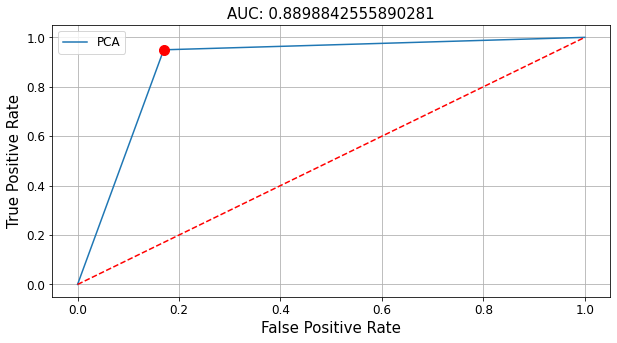

In [88]:
# 예제 데이터 로딩
# 예측치 라벨링 순서가 어떻게 될지 몰라서 순서를 맞추기 위해 Y라벨을 오름차순으로 정렬
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
Y = pd.DataFrame(cancer.target, columns=['Target'])
df = pd.concat([Y, X], axis=1).sort_values(by='Target').reset_index().iloc[:,1:]
Y = np.ravel(df['Target'])
X = df.iloc[:,1:]

# 스케일링
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# 모델링
model_kmeans = KMeans(n_clusters=2, random_state=123)
model_kmeans.fit(X, Y)
Y_pred = model_kmeans.predict(X)

# 성능확인
display(measures_cluster(Y, X, Y_pred))

# Confusion Matrix 확인
display(evaluation_class_ConfusionMatrix(Y, Y_pred))

# Classification Report 확인
evaluation_class_ClassificationReport(Y, Y_pred)

# ROC Curve & AUC 확인
evaluation_class_ROCAUC(Y, Y_pred, label='PCA')

In [89]:
# 예제 데이터 로딩
# 예측치 라벨링 순서가 어떻게 될지 몰라서 순서를 맞추기 위해 Y라벨을 오름차순으로 정렬
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
Y = pd.DataFrame(cancer.target, columns=['Target'])
df = pd.concat([Y, X], axis=1).sort_values(by='Target').reset_index().iloc[:,1:]
Y = np.ravel(df['Target'])
X = df.iloc[:,1:]

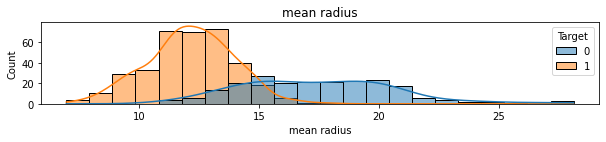

In [90]:
# 변수가 많은 고차원 데이터를 시각화 하는 것은 쉽지 않음
# 분류 여부에 따른 변수별 분포(히스토그램)를 통해 영향력을 확인하는 것이 일반적
for col in X.columns:
    plt.figure(figsize=(10,1.5))
    sns.histplot(data=df, x=col, hue='Target', kde=True)
    plt.title(col)
    plt.show()
    break

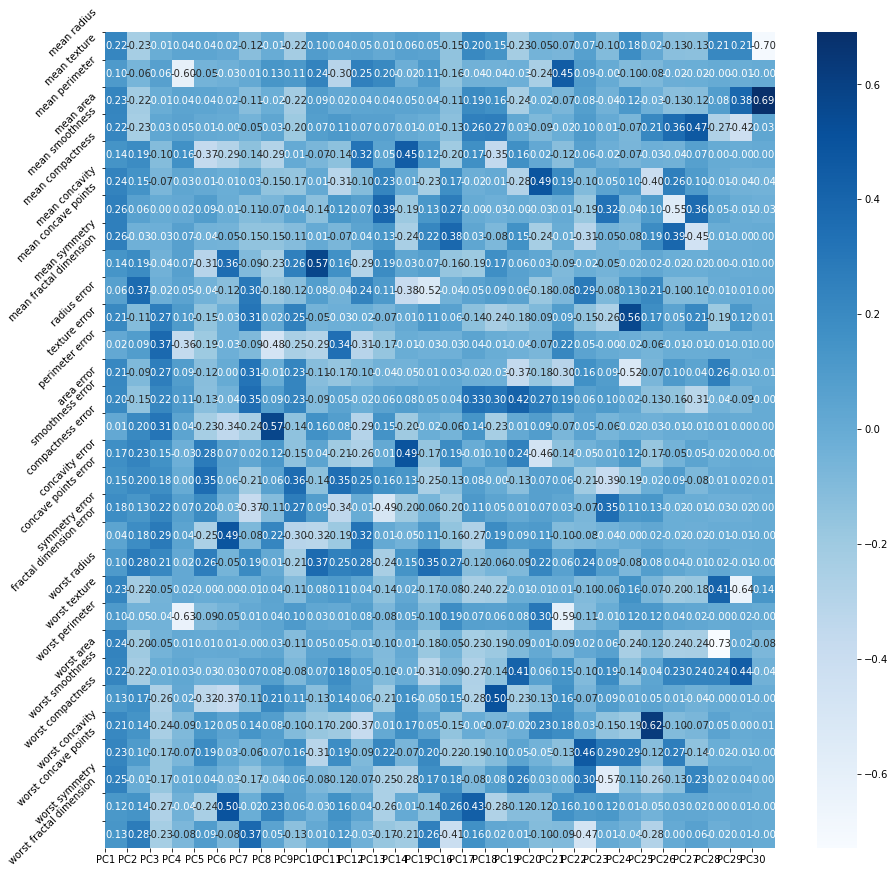

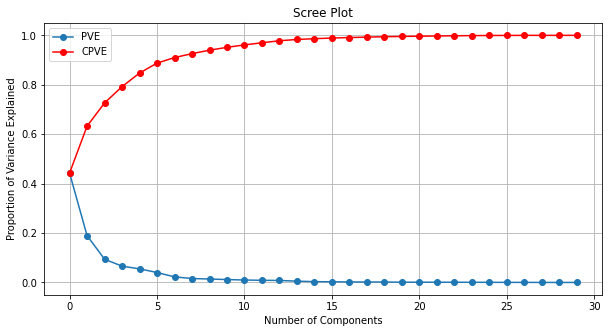

In [91]:
# 스케일링
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# 데이터의 주성분 추출
model_pca = PCA(n_components=X.shape[1])
model_pca.fit(X)
X_pca = model_pca.transform(X)

# 고유벡터 시각화 및 변수별 이해
plt.figure(figsize=(15,15))
sns.heatmap(model_pca.components_.T, cmap='Blues', annot=True, fmt='.2f')
colnames = ['PC'+str(i) for i in range(1, X_pca.shape[1]+1)]
plt.xticks([i for i in range(X_pca.shape[1])], colnames)
plt.yticks([i for i in range(X_pca.shape[1])], cancer.feature_names, rotation=45)
plt.show()

# Scree Plot
plt.figure(figsize=(10,5))
plt.plot(model_pca.explained_variance_ratio_, 'o-', label='PVE')
plt.plot(model_pca.explained_variance_ratio_.cumsum(), 'o-', c='red', label='CPVE')
plt.legend()
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

# 주성분 데이터 정리
colnames = ['PC'+str(i) for i in range(1, X_pca.shape[1]+1)]
X_pca = pd.DataFrame(X_pca, columns=colnames)

In [92]:
# 데이터의 분포 통계량 확인
X_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,...,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
mean,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,...,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
std,3.65,2.39,1.68,1.41,1.29,1.10,0.82,0.69,0.65,0.59,...,0.17,0.17,0.16,0.13,0.12,0.09,0.08,0.04,0.03,0.01
min,-5.57,-7.78,-4.88,-5.13,-4.79,-4.22,-4.08,-3.95,-2.97,-2.74,...,-0.74,-0.72,-0.78,-0.57,-0.48,-0.33,-0.30,-0.19,-0.16,-0.05
25%,-2.76,-1.50,-1.02,-0.79,-0.62,-0.73,-0.45,-0.37,-0.32,-0.37,...,-0.10,-0.09,-0.08,-0.07,-0.07,-0.05,-0.04,-0.02,-0.01,-0.01
50%,-1.17,-0.20,-0.16,0.12,-0.03,-0.07,-0.02,0.01,0.01,0.00,...,-0.00,-0.01,0.00,-0.01,-0.00,-0.01,-0.00,0.00,0.00,0.00
75%,2.51,1.23,0.86,0.97,0.61,0.62,0.45,0.35,0.36,0.33,...,0.09,0.08,0.08,0.07,0.07,0.05,0.04,0.02,0.01,0.01
max,16.32,12.57,10.11,5.19,7.49,5.13,5.42,4.36,3.78,3.19,...,1.12,1.14,0.83,0.64,0.77,0.51,0.39,0.22,0.18,0.07


In [93]:
# 스케일링
scaler = preprocessing.StandardScaler()
X_pca = scaler.fit_transform(X_pca)
pd.DataFrame(X_pca).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,...,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
mean,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,...,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.53,-3.26,-2.91,-3.65,-3.73,-3.84,-4.97,-5.73,-4.60,-4.62,...,-4.26,-4.33,-5.03,-4.24,-3.86,-3.63,-3.64,-4.65,-5.87,-4.09
25%,-0.76,-0.63,-0.61,-0.56,-0.48,-0.66,-0.55,-0.54,-0.50,-0.62,...,-0.55,-0.55,-0.51,-0.49,-0.56,-0.58,-0.53,-0.44,-0.43,-0.45
50%,-0.32,-0.08,-0.09,0.08,-0.02,-0.07,-0.02,0.02,0.02,0.00,...,-0.00,-0.07,0.02,-0.04,-0.03,-0.06,-0.03,0.02,0.07,0.02
75%,0.69,0.51,0.51,0.69,0.48,0.56,0.55,0.51,0.56,0.55,...,0.49,0.48,0.54,0.50,0.54,0.50,0.52,0.42,0.47,0.47
max,4.48,5.27,6.02,3.69,5.83,4.67,6.59,6.32,5.86,5.39,...,6.47,6.90,5.33,4.77,6.23,5.62,4.67,5.50,6.74,6.36


In [94]:
# 사용할 변수의 갯수
num_feature = 9
X_pca = X_pca[:,:num_feature].copy()

# 모델링
model_kmeans = KMeans(n_clusters=2, random_state=123)
model_kmeans.fit(X_pca, Y)
Y_pred = model_kmeans.predict(X_pca)
Y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [95]:
# 성능확인
measures_cluster(np.ravel(Y), X_pca, Y_pred)

,Silhouette,ARI,AMI
Score,0.14,0.78,0.70


In [96]:
# Confusion Matrix 확인
evaluation_class_ConfusionMatrix(Y, Y_pred)

,Pred 0,Pred 1
True 0,181,31
True 1,2,355


In [97]:
# Classification Report 확인
evaluation_class_ClassificationReport(Y, Y_pred)

              precision    recall  f1-score   support

     class 0       0.99      0.85      0.92       212
     class 1       0.92      0.99      0.96       357

    accuracy                           0.94       569
   macro avg       0.95      0.92      0.94       569
weighted avg       0.95      0.94      0.94       569



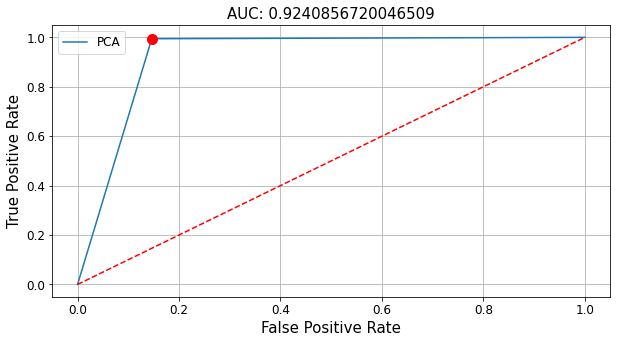

In [98]:
# ROC Curve & AUC 확인
evaluation_class_ROCAUC(Y, Y_pred, label='PCA')

### 타이타닉 생존분류 데이터

(712, 11) (712, 1)
(179, 11) (179, 1)


,Silhouette,ARI,AMI
Score,0.21,0.31,0.24


,Pred 0,Pred 1
True 0,88,26
True 1,13,52


              precision    recall  f1-score   support

     class 0       0.87      0.77      0.82       114
     class 1       0.67      0.80      0.73        65

    accuracy                           0.78       179
   macro avg       0.77      0.79      0.77       179
weighted avg       0.80      0.78      0.79       179



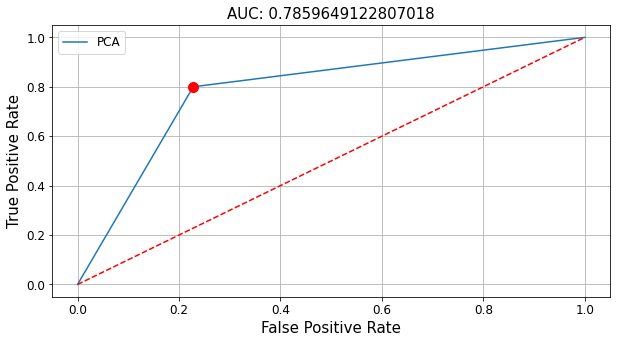

In [99]:
# 타이타닉 생존문제 로딩
from module_classification import *

# 데이터 로딩
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# 데이터 전처리
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)  

scaler = preprocessing.StandardScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

# 모델링
model_kmeans = KMeans(n_clusters=2, random_state=123)
model_kmeans.fit(X_train_fes, Y_train)
Y_trpred = model_kmeans.predict(X_train_fes)
Y_tepred = model_kmeans.predict(X_test_fes)

# Test 성능확인
display(measures_cluster(np.ravel(Y_test), X_test_fes, Y_tepred))

# Confusion Matrix 확인
display(evaluation_class_ConfusionMatrix(Y_test, Y_tepred))

# Classification Report 확인
evaluation_class_ClassificationReport(Y_test, Y_tepred)

# ROC Curve & AUC 확인
evaluation_class_ROCAUC(Y_test, Y_tepred, label='PCA')

In [100]:
# 타이타닉 생존문제 로딩
from module_classification import *

# 데이터 로딩
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# 데이터 전처리
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)  

scaler = preprocessing.StandardScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

(712, 11) (712, 1)
(179, 11) (179, 1)


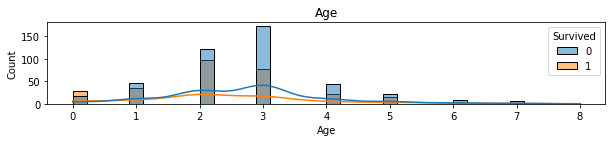

In [101]:
# 변수가 많은 고차원 데이터를 시각화 하는 것은 쉽지 않음
# 분류 여부에 따른 변수별 분포(히스토그램)를 통해 영향력을 확인하는 것이 일반적
for col in X_train_fe.columns:
    if col == 'Age':
        plt.figure(figsize=(10,1.5))
        sns.histplot(data=pd.concat([Y_train, X_train_fe], axis=1), x=col, hue=Y_colname[0], kde=True)
        plt.title(col)
        plt.show()

In [102]:
# 데이터의 주성분 추출
model_pca = PCA(n_components=X_train_fes.shape[1])
model_pca.fit(X_train_fes)
X_train_pca = model_pca.transform(X_train_fes)
X_test_pca = model_pca.transform(X_test_fes)

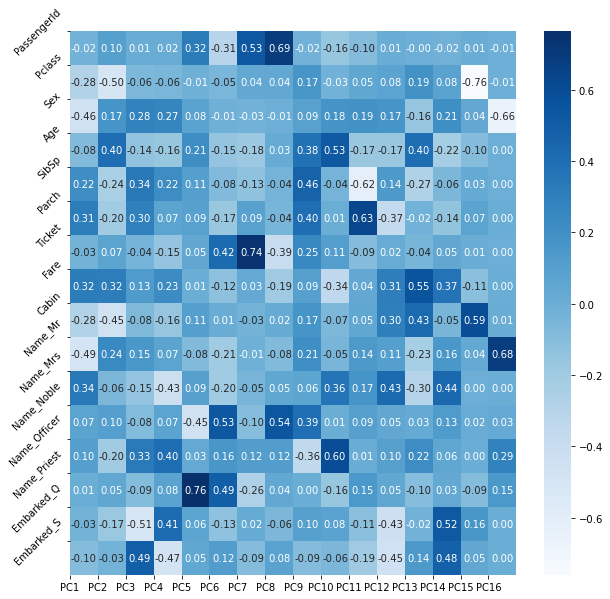

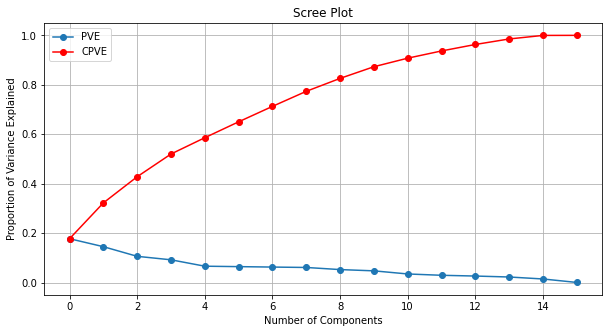

In [103]:
# 고유벡터 시각화 및 변수별 이해
plt.figure(figsize=(10,10))
sns.heatmap(model_pca.components_.T, cmap='Blues', annot=True, fmt='.2f')
colnames = ['PC'+str(i) for i in range(1, X_train_pca.shape[1]+1)]
plt.xticks([i for i in range(X_train_pca.shape[1])], colnames)
plt.yticks([i for i in range(X_train_pca.shape[1])], X_train_fes.columns, rotation=45)
plt.show()

# Scree Plot
plt.figure(figsize=(10,5))
plt.plot(model_pca.explained_variance_ratio_, 'o-', label='PVE')
plt.plot(model_pca.explained_variance_ratio_.cumsum(), 'o-', c='red', label='CPVE')
plt.legend()
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

# 주성분 데이터 정리
colnames = ['PC'+str(i) for i in range(1, X_train_pca.shape[1]+1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=colnames)
X_test_pca = pd.DataFrame(X_test_pca, columns=colnames)

In [104]:
# 데이터의 분포 통계량 확인
X_train_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
count,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,1.68,1.52,1.30,1.21,1.03,1.01,1.00,0.99,0.92,0.87,0.74,0.68,0.65,0.60,0.48,0.07
min,-2.02,-4.03,-3.80,-2.69,-6.77,-2.63,-3.46,-2.80,-3.04,-3.22,-3.28,-2.16,-1.86,-1.78,-1.37,-0.99
25%,-1.58,-0.91,-0.58,-0.64,-0.36,-0.50,-0.60,-0.64,-0.47,-0.47,-0.40,-0.44,-0.35,-0.35,-0.31,-0.01
50%,-0.32,-0.15,0.30,-0.26,-0.05,-0.13,-0.08,-0.01,-0.05,-0.07,-0.01,0.02,-0.03,0.10,-0.17,0.00
75%,1.35,0.72,0.54,0.59,0.25,0.24,0.51,0.60,0.42,0.42,0.31,0.30,0.30,0.34,0.33,0.01
max,4.81,5.74,4.95,5.05,8.17,7.67,3.61,7.99,5.08,4.62,3.91,3.21,5.59,2.53,1.57,1.31


In [105]:
# 스케일링
scaler = preprocessing.StandardScaler()
X_train_pca, X_test_pca = scale(scaler, X_train_pca, X_test_pca)
pd.DataFrame(X_train_pca).describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
count,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00
mean,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.20,-2.65,-2.92,-2.22,-6.59,-2.60,-3.46,-2.84,-3.33,-3.70,-4.41,-3.16,-2.88,-2.98,-2.87,-14.87
25%,-0.94,-0.60,-0.45,-0.53,-0.35,-0.49,-0.60,-0.65,-0.51,-0.55,-0.54,-0.65,-0.55,-0.59,-0.66,-0.13
50%,-0.19,-0.10,0.23,-0.22,-0.05,-0.13,-0.08,-0.01,-0.06,-0.08,-0.01,0.02,-0.05,0.16,-0.36,0.00
75%,0.80,0.47,0.42,0.49,0.24,0.24,0.51,0.61,0.46,0.48,0.41,0.45,0.46,0.57,0.69,0.11
max,2.86,3.77,3.80,4.16,7.95,7.57,3.61,8.10,5.56,5.32,5.25,4.69,8.64,4.24,3.28,19.60


In [106]:
# 사용할 변수의 갯수
num_feature = 3
X_train_pca = X_train_pca.iloc[:,:num_feature].copy()
X_test_pca = X_test_pca.iloc[:,:num_feature].copy()

# 모델링
model_kmeans = KMeans(n_clusters=2, random_state=123)
model_kmeans.fit(X_train_pca, Y_train)
Y_trpred = model_kmeans.predict(X_train_pca)
Y_tepred = model_kmeans.predict(X_test_pca)

In [107]:
# 성능확인
measures_cluster(np.ravel(Y_test), X_test_pca, Y_tepred)

,Silhouette,ARI,AMI
Score,0.37,0.34,0.25


In [108]:
# Confusion Matrix 확인
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

,Pred 0,Pred 1
True 0,90,24
True 1,13,52


In [109]:
# Classification Report 확인
evaluation_class_ClassificationReport(Y_test, Y_tepred)

              precision    recall  f1-score   support

     class 0       0.87      0.79      0.83       114
     class 1       0.68      0.80      0.74        65

    accuracy                           0.79       179
   macro avg       0.78      0.79      0.78       179
weighted avg       0.80      0.79      0.80       179



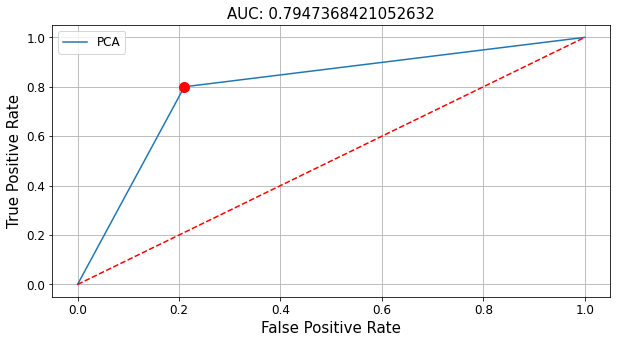

In [110]:
# ROC Curve & AUC 확인
evaluation_class_ROCAUC(Y_test, Y_tepred, label='PCA')